# Predicting football player value

*Mathilde Cros (s231738), Tu Nguyen (s231814), Yassine Turki (s231735), Dimitrije Zdrale (s231734)*


This project is divided into two parts:

Firstly, we use clustering methods and classification to highlight the different features for each class of players (positions).
Then, we subdivide our dataset to create subgroups of a specific position and use clustering and regression methods to investigate which performance metrics of players we should look at first when evaluating a football players’ skills fir a given position. Indeed, we are interested in the strictly technical and physical skills of players and whether a single feature will come out to be the most important when considering a player. By doing so, this project thus aims to be a technical supplement to the strategic and business related decision making process of player recruiters.

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import sklearn.neighbors
from sklearn.linear_model import ElasticNet, RidgeCV, LassoCV, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from xgboost import XGBRegressor
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import graphviz
from IPython.display import display
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Data Preprocessing

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')
# path = "drive/MyDrive/Comp_Tools_Data_Science/football_data/"
path = "football_data/"

The data contains 7 datasets of players from the top 7 leagues in the UEFA system, with their social and technical information during season 2022-2023.

In [8]:
# Load the dataset
epl_df = pd.read_csv(path +'epl_stats.csv')
bun_df = pd.read_csv(path +'bundesliga_stats.csv')
laliga_df = pd.read_csv(path +'laliga_stats.csv')
seria_df = pd.read_csv(path +'seria_stats.csv')
ere_df = pd.read_csv(path +'eredivisie_stats.csv')
l1_df = pd.read_csv(path +'league1_stats.csv')
nos_df = pd.read_csv(path +'liganos_stats.csv')


In [11]:
datasets = {'epl': epl_df, 'bundesliga': bun_df, 'laliga': laliga_df, 'seria': seria_df, 'eredivisie': ere_df, 'league1': l1_df, 'liganos': nos_df}

# Loop through each DataFrame
for name, df in datasets.items():
    # Check if there exists a value in "average_rating_overall" > 10
    if (df['average_rating_overall'] >10).any():
        print(f"\nDataFrame with values > 10: {name}")

In [12]:
df_list = [epl_df, bun_df, laliga_df, seria_df, ere_df, l1_df, nos_df]

Check if all the dataframes have the same set of column.

In [13]:
if (set(epl_df.columns) == set(bun_df.columns) == set(laliga_df.columns) == set(seria_df.columns) == set(l1_df.columns) == set(ere_df.columns) == set(nos_df.columns)):
    print("All dataframes have the same set of columns.")
else:
    print("Dataframes have different sets of columns.")

All dataframes have the same set of columns.


Since all the dataframes have the same set of column, we can concatenate them to get the final dataframe. For each dataframe above, we generate a column "league" to help distinguish after the concatenation.

In [14]:
# Add a "league" column to each dataframe
for i in range (len(df_list)):
  df_list[i]['league'] = i+1

Concatenate the dataframes.

In [15]:
# Concatenate the dataframes into one big dataframe
df = pd.concat([epl_df, laliga_df, seria_df, bun_df, ere_df, l1_df, nos_df], ignore_index=True)

Check the number of players we have after concatenating the 7 datasets.

In [16]:
print("Total number of players:", df.shape[0])

Total number of players: 4582


In [17]:
df.head(5)

,full_name,age,birthday,birthday_GMT,league,season,position,Current Club,minutes_played_overall,minutes_played_home,...,annual_salary_eur_percentile,clean_sheets_percentage_percentile_overall,min_per_card_percentile_overall,cards_per90_percentile_overall,booked_over05_overall,booked_over05_percentage_overall,booked_over05_percentage_percentile_overall,shirt_number,annual_salary_gbp,annual_salary_usd
0,Aaron Cresswell,33,629712000,1989/12/15,1,2022/2023,Defender,West Ham United,2235,1108,...,23.0,59.0,81.0,30.0,3.0,11.0,44.0,3.0,0.0,0.0
1,Aaron Hickey,21,1023692400,2002/06/10,1,2022/2023,Defender,Brentford,1930,1076,...,23.0,43.0,31.0,80.0,7.0,0.0,11.0,2.0,0.0,0.0
2,Aaron Ramsdale,25,895129200,1998/05/14,1,2022/2023,Goalkeeper,Arsenal,3420,1710,...,91.0,80.0,99.0,11.0,1.0,3.0,14.0,1.0,NaN,NaN
3,Aaron Wan-Bissaka,25,880531200,1997/11/26,1,2022/2023,Defender,Manchester United,1436,721,...,95.0,98.0,80.0,33.0,2.0,11.0,44.0,29.0,NaN,NaN
4,Abdoulaye Doucouré,30,725875200,1993/01/01,1,2022/2023,Midfielder,Everton,1527,859,...,97.0,43.0,17.0,93.0,6.0,24.0,86.0,16.0,NaN,NaN


In [18]:
# Get all columns with missing values
columns_with_na = df.columns[df.isna().any()].tolist()

# Print the list of columns with missing values
# print("Columns with missing values:")
# for col in columns_with_na:
#     print(col)

Drop all players who don't have an average rating

In [19]:
df = df.dropna(subset=['average_rating_overall'])
df = df[df["average_rating_overall"] != 0]
print("Length of the cleaned DataFrame:", len(df))

Length of the cleaned DataFrame: 3479


Drop all columns where all the values are 0

In [20]:
zero_columns = df.columns[(df == 0).all()]
df = df.drop(columns=zero_columns)

print("Dropped columns with all 0 values:")
for col in zero_columns:
    print(col)

# Calculate the number of columns left
columns_left = df.shape[1]
columns_deleted = len(zero_columns)

print("Number of columns left:", columns_left)
print("Number of columns deleted:", columns_deleted)

Dropped columns with all 0 values:
short_passes_per_game_overall
long_passes_per_game_overall
through_passes_per_game_overall
tackles_successful_per_game_overall
possession_regained_per_game_overall
pressures_per_game_overall
distance_travelled_per_game_overall
chances_created_per_game_overall
aerial_duels_per_game_overall
possession_regained_per_90_overall
tackles_successful_per_90_overall
tackles_successful_total_overall
through_passes_total_overall
through_passes_per_90_overall
long_passes_total_overall
long_passes_per_90_overall
short_passes_total_overall
short_passes_per_90_overall
chances_created_total_overall
chances_created_per_90_overall
shots_per_goal_conceded_overall
pressures_total_overall
pressures_per_90_overall
pen_save_percentage_overall
aerial_duels_total_overall
aerial_duels_per_90_overall
aerial_duels_won_percentage_overall
progressive_passes_total_overall
distance_travelled_total_overall
distance_travelled_per_90_overall
man_of_the_match_total_overall
Number of colu

We want to sort the players based on their average rating.

In [21]:
df = df.sort_values(by='average_rating_overall', ascending=False)
column_values = df.pop("average_rating_overall")
df.insert(len(df.columns), "average_rating_overall", column_values)
df.head(20)

,full_name,age,birthday,birthday_GMT,league,season,position,Current Club,minutes_played_overall,minutes_played_home,...,clean_sheets_percentage_percentile_overall,min_per_card_percentile_overall,cards_per90_percentile_overall,booked_over05_overall,booked_over05_percentage_overall,booked_over05_percentage_percentile_overall,shirt_number,annual_salary_gbp,annual_salary_usd,average_rating_overall
4543,Víto Ferreira,26,874566000,1997/09/18,7,2022/2023,Midfielder,Casa Pia,65,28,...,43.0,10.0,99.0,1.0,25.0,86.0,18.0,NaN,NaN,8.84
2762,Cody Gakpo,24,926060400,1999/05/07,5,2022/2023,Forward,PSV,1127,573,...,34.0,17.0,17.0,0.0,0.0,18.0,11.0,NaN,NaN,8.35
2009,Salvatore Sirigu,36,537436800,1987/01/12,4,2022/2023,Goalkeeper,Fiorentina,90,0,...,99.0,10.0,10.0,0.0,0.0,11.0,56.0,NaN,NaN,8.32
2713,Antony,23,951379200,2000/02/24,5,2022/2023,Forward,Ajax,180,90,...,1.0,17.0,17.0,0.0,0.0,18.0,11.0,NaN,NaN,8.29
3635,Lionel Messi,36,551516400,1987/06/24,6,2022/2023,Forward,PSG,2842,1589,...,92.0,14.0,14.0,0.0,0.0,14.0,30.0,NaN,NaN,8.15
3339,Armand Lauriente,24,912758400,1998/12/04,6,2022/2023,Forward,Lorient,269,90,...,82.0,14.0,14.0,0.0,0.0,14.0,45.0,NaN,NaN,8.06
2811,Dušan Tadić,34,596016000,1988/11/20,5,2022/2023,Midfielder,Ajax,2971,1487,...,69.0,78.0,41.0,3.0,9.0,56.0,10.0,NaN,NaN,8.02
2656,Tjark Ernst,20,1047715200,2003/03/15,2,2022/2023,Goalkeeper,Hertha BSC,90,0,...,2.0,11.0,11.0,0.0,0.0,11.0,12.0,NaN,NaN,8.02
4349,Matheus Nunes,25,904201200,1998/08/27,7,2022/2023,Midfielder,Sporting CP,180,90,...,96.0,16.0,94.0,1.0,50.0,99.0,8.0,NaN,NaN,7.93
51,Asmir Begović,36,551170800,1987/06/20,1,2022/2023,Goalkeeper,Everton,90,90,...,99.0,10.0,10.0,0.0,0.0,11.0,15.0,NaN,NaN,7.91


Delete all columns which have more than 80% of the data not filled.

In [22]:
columns_before_drop = df.shape[1]

df = df.dropna(axis=1, thresh=0.8*len(df))

# Calculate the number of columns left
columns_after_drop = df.shape[1]

# Calculate the number of columns deleted
columns_deleted = columns_before_drop - columns_after_drop

# Print the results
print("Number of columns deleted:", columns_deleted)
print("Number of columns left:", columns_after_drop)


Number of columns deleted: 8
Number of columns left: 238


In [23]:
# for col in df.columns:
#   print(col)

Check if there are still blank cells and fill them using the mean if the column.

In [24]:
for col in df.columns:
    # Check if there are N/A values in the column
    na_count = df[col].isna().sum()

    if na_count > 0:
        # Print the column name and the number of N/A values
        print(f"Column '{col}' has {na_count} N/A values.")

        # Fill N/A values with a specific value (e.g., fill with 0)
        df[col].fillna(df[col].mean(), inplace=True)

Column 'possession_regained_total_overall' has 11 N/A values.
Column 'save_percentage_percentile_overall' has 6 N/A values.
Column 'market_value' has 11 N/A values.
Column 'market_value_percentile' has 11 N/A values.
Column 'annual_salary_eur' has 7 N/A values.


In [25]:
# # Sort the dataframe by "salary" in descending order
# df_sorted = df.sort_values(by="annual_salary_eur", ascending=False)

# # Print the first 50 player names and their corresponding salaries after sorting
# print(df_sorted[["full_name", "annual_salary_eur"]].head(50))

Remove highly correlated columns.

In [26]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Create a mask to identify highly correlated pairs
# Set a correlation threshold (0.85) to consider columns as highly correlated
corr_threshold = 0.85
mask = (corr_matrix.abs() > corr_threshold) & (corr_matrix.abs() < 1.0)

# Remove one column from each highly correlated pair
columns_to_drop = set()
for col in mask.columns:
  if col in columns_to_drop:
    # print("The column", col, "was already dropped!")
    continue
  correlated_cols = mask.index[mask[col]].tolist()
  if len(correlated_cols) >= 1:
      # print(col, "is correlated with", correlated_cols)
      columns_to_drop |= set(correlated_cols)

columns_to_drop.add("average_rating_percentile_overall")


# Drop the highly correlated columns from the DataFrame
df_cleaned = df.drop(columns=columns_to_drop, axis=1, errors="ignore")

print(f"Number of columns left: {len(df_cleaned.columns)}")

Number of columns left: 151


In [27]:
df_cleaned.head()

,full_name,age,birthday_GMT,league,season,position,Current Club,minutes_played_overall,nationality,goals_overall,...,goals_involved_per90_percentile_overall,goals_per90_percentile_away,goals_per90_percentile_home,annual_salary_eur,annual_salary_eur_percentile,clean_sheets_percentage_percentile_overall,cards_per90_percentile_overall,booked_over05_percentage_overall,shirt_number,average_rating_overall
4543,Víto Ferreira,26,1997/09/18,7,2022/2023,Midfielder,Casa Pia,65,Portugal,0,...,25.0,57.0,52.0,30000.0,24.0,43.0,99.0,25.0,18.0,8.84
2762,Cody Gakpo,24,1999/05/07,5,2022/2023,Forward,PSV,1127,Netherlands,9,...,99.0,88.0,99.0,1137233.0,92.0,34.0,17.0,0.0,11.0,8.35
2009,Salvatore Sirigu,36,1987/01/12,4,2022/2023,Goalkeeper,Fiorentina,90,Italy,0,...,24.0,57.0,51.0,1209795.0,71.0,99.0,10.0,0.0,56.0,8.32
2713,Antony,23,2000/02/24,5,2022/2023,Forward,Ajax,180,Brazil,1,...,99.0,54.0,99.0,11933376.0,99.0,1.0,17.0,0.0,11.0,8.29
3635,Lionel Messi,36,1987/06/24,6,2022/2023,Forward,PSG,2842,Argentina,16,...,99.0,96.0,91.0,40500000.0,99.0,92.0,14.0,0.0,30.0,8.15


In [28]:
categorical_columns = df_cleaned.select_dtypes(include=['object']).columns

# Print the columns with categorical data
print("Columns with categorical data:")
for col in categorical_columns:
    print(col)

Columns with categorical data:
full_name
birthday_GMT
season
position
Current Club
nationality


In [29]:
categorical_columns = categorical_columns.drop("position")
categorical_columns

Index(['full_name', 'birthday_GMT', 'season', 'Current Club', 'nationality'], dtype='object')

In [30]:
unique_positions = df_cleaned['position'].unique()
# Print each unique value
print("Unique values in the 'position' column:")
for position in unique_positions:
    print(position)


Unique values in the 'position' column:
Midfielder
Forward
Goalkeeper
Defender


In [31]:
categorical_columns = categorical_columns.drop("full_name")
categorical_columns

Index(['birthday_GMT', 'season', 'Current Club', 'nationality'], dtype='object')

We encode the positions into labels:

- GoalKeeper : 1
- Defender : 2
- Midfielder : 3
- Forward : 4

In [32]:
df_cleaned = df_cleaned.drop(columns = categorical_columns, errors="ignore")
df_cleaned['position'] = df_cleaned['position'].map({'Goalkeeper':1 , 'Defender': 2, "Midfielder":3, "Forward":4}).astype(int)
df_cleaned= df_cleaned.reset_index(drop=True)


In [33]:
description = df_cleaned.describe(include='all')

# Transpose the result to display all columns
description_transposed = description.transpose()
description_transposed.head(50)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
full_name,3479,3366,Antony,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,3479.0,NaN,NaN,NaN,26.805116,4.317538,17.0,24.0,26.0,30.0,42.0
league,3479.0,NaN,NaN,NaN,3.98879,2.001908,1.0,2.0,4.0,6.0,7.0
position,3479.0,NaN,NaN,NaN,2.764013,0.924905,1.0,2.0,3.0,4.0,4.0
minutes_played_overall,3479.0,NaN,NaN,NaN,1333.248922,967.850162,0.0,450.0,1245.0,2144.5,3420.0
goals_overall,3479.0,NaN,NaN,NaN,1.812877,3.220709,0.0,0.0,1.0,2.0,36.0
assists_overall,3479.0,NaN,NaN,NaN,1.265019,1.978293,0.0,0.0,0.0,2.0,17.0
assists_away,3479.0,NaN,NaN,NaN,0.549871,1.042112,0.0,0.0,0.0,1.0,14.0
penalty_goals,3479.0,NaN,NaN,NaN,0.163553,0.707704,0.0,0.0,0.0,0.0,10.0
penalty_misses,3479.0,NaN,NaN,NaN,0.052026,0.263553,0.0,0.0,0.0,0.0,4.0


Here again, in the same way that we're dropping positions and overall_ranking, we also need to get rid of the ranking per position of the players.

In [34]:
df_cleaned = df_cleaned.drop(columns = ['rank_in_league_top_attackers','rank_in_league_top_midfielders','rank_in_league_top_defenders'], errors = "ignore")


We need to normalize the data

In [35]:
pca_data = df_cleaned.drop(columns=["league","full_name"], errors = "ignore")
X=pca_data.drop(columns=["position"])
y=pca_data["position"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Display the shapes of the resulting sets
print("Training set shape:", X_train_scaled.shape)
print("Testing set shape:", X_test_scaled.shape)

Training set shape: (2783, 141)
Testing set shape: (696, 141)


## PCA Model

In this task, we will try to reduce the number of features we have using a principal component analysis (PCA). Our first goal is to predict the position of a player given his statistics. We will first train a classifier without PCA, then train the same classifier using the data with reduced dimensionality and compare results.  


In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

### Logistic Regression Classifier without PCA

For this classification problem, we choose to use the Logistic regression classifier.

In [ ]:
# Train a classifier on the transformed data
classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 1000000)
classifier.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:\n', classification_report_result)

As we can see, our model has a great performance. However, the accuracy could be optimized if the model could train on relevant features of a reduced number. We thus apply PCA. First, we use the MLE to try to guess the number of components. Then, we use cross validation to iterate over the number of possible components (144) and select the best number that maximizes accuracy.

In [ ]:
pca1 = decomposition.PCA(n_components = 'mle')
pca1.fit(X_train_scaled)
X_train_transformed = pca1.transform(X_train_scaled) # => Apply dimensionality reduction to X.

In [ ]:
print(pca1.explained_variance_ratio_)
print(pca1.singular_values_)
print(pca1.get_covariance())
print("Number of componeents found by MLE",pca1.n_components_)

In [ ]:
pca2 = PCA(n_components='mle')
X_train_pca = pca2.fit_transform(X_train_scaled)
X_test_pca = pca2.transform(X_test_scaled)

# Train a classifier on the transformed data
classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 1000000)
classifier.fit(X_train_pca, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test_pca)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:\n', classification_report_result)

### Finding the best number of components for PCA using Gridsearch

In [ ]:
# We have commented this cell as the cross validation for PCA takes a bit of time. Uncomment the cell if you would like to retrive the best number of principal components.

# # Set up the pipeline with PCA and LogisticRegression
# pipeline = Pipeline([
#     ('pca', PCA()),
#     ('classifier', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 1000000))
# ])

# # Define the parameter grid for grid search
# param_grid = {
#     'pca__n_components': range(1, 144)
# }

# # Create the GridSearchCV object
# grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='accuracy')

# # Fit the GridSearchCV object to the data
# grid_search.fit(X_train_scaled, y_train)

# # Get the best number of components from the grid search
# best_n_components = grid_search.best_params_['pca__n_components']

# # Perform PCA with the best number of components
# pca = PCA(n_components=best_n_components)
# X_train_pca = pca.fit_transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)

# # Train a classifier on the transformed data
# classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 1000000)
# classifier.fit(X_train_pca, y_train)

# # Make predictions on the test set
# y_pred = classifier.predict(X_test_pca)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# classification_report_result = classification_report(y_test, y_pred)

# print(f'Best Number of Components: {best_n_components}')
# print(f'Accuracy: {accuracy:.2f}')
# print('Classification Report:\n', classification_report_result)


As we can see, the best number of principal components is $n = 89$. However, due to the low interpretability of these components, we choose to drop PCA and move to clustering, as our goal is to explore if players who play in the same position have similar attributes and could be regrouped into clusters, without knowing their actual position.
Overall, this result tells us that it is possible to find the same information with less features. This implies multiple correlations between the players' features, which makes our prediction of the "only one best feature" more tricky.

## Clustering

Our clustering analysis will have two subparts:
- First, we are interested in knowing if players who share the same position actually have similar attributes. We would like to form clusters based on the player's position, using an unsupervised learning task.
- Then, we would like to investigate if the best players within a given position have similar attributes. For example, do all top 10 forwards possess exceptional speed? Do all top 10 defenders have a high tackle success rate?

### Task 1: Clustering by position

In [ ]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering, AffinityPropagation, BisectingKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import seaborn as sns
import math

In [ ]:
df_clean = df_cleaned
clustering_data_1 = df_cleaned
clustering_data_2 = df_cleaned

In [ ]:
clustering_data_1.head(10)

In [ ]:
clustering_data_1.shape

In [ ]:
clustering_data_1 = clustering_data_1.drop(columns=["league","position", "full_name"], errors = "ignore")

In [ ]:
# 1. Cluster into positions

# Perform KMeans clustering for different values of k and plot WCSS
wcss_values = []
k_max = math.floor(1.5 * math.sqrt(clustering_data_1.shape[0])) + 1
k_range = range(1, k_max, 3)

for k in k_range:
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init = "auto")
    kmeans_labels = kmeans_model.fit_predict(clustering_data_1)
    wcss_values.append(kmeans_model.inertia_)

plt.plot(range(1, k_max, 3), wcss_values, c='red', marker='o', label='Data Points')
plt.title('Elbow Method for Optimal k (K-means) - All Positions')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')

# Set x-axis ticks at specified intervals
x_ticks = np.arange(1, k_max, 3)
plt.xticks(x_ticks)
plt.show()

Here we can see that we have the elbow part at a number of clusters of 4 which is the amount of positions we have in our dataset. The fact that we have been able to retrieve this number analytically implies that players within the same position share similar stats, and that it might be more interesting to further investigate features within a subgroup.

In [ ]:
k_optimal = 4

# Fit KMeans with the optimal k to the entire dataset
final_kmeans_model = KMeans(n_clusters=k_optimal, random_state=42)
features_for_clustering = clustering_data_1[['average_rating_overall', 'saves_per_game_overall', 'shots_per_90_overall', 'tackles_per_90_overall']]
final_kmeans_labels = final_kmeans_model.fit_predict(features_for_clustering)

# Add a new column to the original dataframe for cluster labels
clustering_data_1['cluster_label'] = final_kmeans_labels

# Visualize the clusters for 'saves_per_game_overall' using a scatter plot - a feature we suppose to be specific to goal keepers
plt.figure(figsize=(10, 8))
scatter_goals = plt.scatter(features_for_clustering['average_rating_overall'], features_for_clustering['saves_per_game_overall'], c=final_kmeans_labels, cmap='viridis')
plt.title('Clustering Results - Goals Saved')
plt.xlabel('Average Rating Overall')
plt.xticks([])  # Remove x-axis ticks
plt.ylabel('Saves Per Game Overall')
plt.legend(*scatter_goals.legend_elements(), title='Clusters')
plt.show()

# Visualize the clusters for 'shots_per_90_overall' using a scatter plot - a feature we suppose to be specific to attackers and midfielders
plt.figure(figsize=(10, 8))
scatter_shots = plt.scatter(features_for_clustering['average_rating_overall'], features_for_clustering['shots_per_90_overall'], c=final_kmeans_labels, cmap='viridis')
plt.title('Clustering Results - Shots Taken')
plt.xlabel('Average Rating Overall')
plt.xticks([])  # Remove x-axis ticks
plt.ylabel('Shots Per 90 Overall')
plt.legend(*scatter_shots.legend_elements(), title='Clusters')
plt.show()

# Visualize the clusters for 'tackles_per_90_overall' using a scatter plot - a feature we suppose to be specific to midfielders and defenders
plt.figure(figsize=(10, 8))
scatter_tackles = plt.scatter(features_for_clustering['average_rating_overall'], features_for_clustering['tackles_per_90_overall'], c=final_kmeans_labels, cmap='viridis')
plt.title('Clustering Results - Tackles Made')
plt.xlabel('Average Rating Overall')
plt.xticks([])  # Remove x-axis ticks
plt.ylabel('Tackles Per 90 Overall')
plt.legend(*scatter_tackles.legend_elements(), title='Clusters')
plt.show()

Here we can see that there is indeed some clustering that is possible by position. From the results of the clustering, we see that here all the players in the yellow cluster correspond to goalkeepers as they are obviously the players that will have non-zero statistics for goals saved per game. From the other two plots we could guess that the players in the green clusters are attackers as they are those who shoot most per 90 minutes overall, while the players from the blue cluster are those who tackle most per 90 minutes overall so they are most likely the defenders. Lastly, for the players in the purple cluster, since they are the second most players to tackle, and to shoot per 90 minutes, they would logically be the midfielders.

As we clearly have clusters of players sharing similar features, it is more relevant to cluster players within the same position and look at these features in detail.

### Task 2: finding clusters within the same position

In a previous analysis, we have noticed that we have too many features that are highly corrlelated or redundant, which has considerably diminshed the capability of our clustering algorithms to find accurate clusters. Therefore, we decide here to select features that are not redundant and with low correlation.

In [ ]:
player_stats_list = [
    'age', 'assists_overall', 'assists_away',
    'goals_involved_per_90_overall', 'assists_per_90_overall', 'min_per_match', 'assists_per_game_overall', 'passes_per_90_overall',
    'pass_completion_rate_percentile_overall', 'key_passes_per_game_overall',
    'crosses_per_game_overall', 'tackles_per_90_overall', 'dribbles_successful_per_game_overall',
    'shots_per_90_overall', 'shots_on_target_per_game_overall', 'possession_regained_per90_percentile_overall',
    'interceptions_per_90_overall', 'crosses_per_90_overall', 'through_passes_per90_percentile_overall',
    'key_passes_per_90_overall', 'dribbles_per_90_overall', 'dribbles_successful_percentage_overall',
    'chances_created_per90_percentile_overall', 'pressures_per90_percentile_overall', 'dribbled_past_per_90_overall',
    'clearances_per_game_overall', 'clearances_per_90_overall',
    'fouls_drawn_per_90_overall', 'fouls_committed_per_90_overall',
    'clearances_per90_percentile_overall', 'offsides_per90_percentile_overall', 'aerial_duels_won_per_90_overall',
    'duels_per_90_overall', 'duels_won_percentage_overall', 'distance_travelled_per90_percentile_overall',
    'accurate_crosses_per_90_overall'
]
print(len(player_stats_list))
goalkeeper_stats_list = ['age', 'minutes_played_overall', 'min_per_match', 'clean_sheets_overall', 'conceded_home', 'conceded_away', 'conceded_per_90_overall', 'assists_per_game_overall', 'passes_per_game_overall', 'crosses_per_game_overall', 'saves_per_game_overall', 'long_passes_per90_percentile_overall', 'blocks_per_game_overall', 'clearances_per_game_overall', 'pens_saved_total_overall', 'aerial_duels_won_per90_percentile_overall', 'clean_sheets_percentage_percentile_overall']

In [ ]:
dataframe_position = dict()
normalized_data_position_dict = dict()
scaler = MinMaxScaler()
positions = clustering_data_2['position'].unique()
for position in positions:
    position_data = clustering_data_2[clustering_data_2['position'] == position].drop(columns=['league', 'position', 'annual_salary_eur', 'annual_salary_eur_percentile', 'shirt_number'])
    position_data = position_data.loc[:, (position_data != 0).any(axis=0)]
    dataframe_position[position] = position_data
    if position == 1:
      position_data = position_data[goalkeeper_stats_list]
    else:
      position_data = position_data[player_stats_list]
    position_data_normalized = scaler.fit_transform(position_data)
    normalized_data_position_dict[position] = position_data_normalized
    print(f"\nClustering for {position} with {position_data.shape[0]} players:")

In [ ]:
df_clean

In [ ]:
#Cluster by position
for position in positions:
    # Perform KMeans clustering for different values of k and plot WCSS
    wcss_kmeans, wcss_spectral, wcss_bisect = [], [], []
    silhouettes_kmeans, silhouettes_spectral = [], []
    calinskis_kmeans, calinskis_spectral = [], []
    davies_bouldins_kmeans, davies_bouldins_spectral = [], []

    data = normalized_data_position_dict[position]
    k_min = 2
    k_max = math.floor(1.5* math.sqrt(data.shape[0]))+1
    k_r = 4

    k_range = range(k_min, k_max, k_r)

    AffinityPropagation_model = AffinityPropagation()
    AffinityPropagation_labels = AffinityPropagation_model.fit_predict(normalized_data_position_dict[position])
    s_a, c_a, d_a = silhouette_score(data, AffinityPropagation_labels), calinski_harabasz_score(data, AffinityPropagation_labels), davies_bouldin_score(data, AffinityPropagation_labels)
    print(f'Position {position}: ')
    print(f'AffinityPropagation: Silhouette: {s_a}, Calinski: {c_a}, Davies-Bouldin: {d_a}')

    for k in k_range:
        kmeans_model = KMeans(n_clusters=k, random_state=42, n_init = "auto")
        kmeans_labels = kmeans_model.fit_predict(data)
        spectral_model = SpectralClustering(n_clusters=k, assign_labels='discretize', random_state=0)
        spectral_labels = spectral_model.fit_predict(data)
        bisect_model = BisectingKMeans(n_clusters=k, random_state=0)
        bisect_labels = bisect_model.fit_predict(data)



        s_k, c_k, d_k = silhouette_score(data, kmeans_labels), calinski_harabasz_score(data, kmeans_labels), davies_bouldin_score(data, kmeans_labels)
        s_s, c_s, d_s = silhouette_score(data, spectral_labels), calinski_harabasz_score(data, spectral_labels), davies_bouldin_score(data, spectral_labels)
        s_b, c_b, d_b = silhouette_score(data, bisect_labels), calinski_harabasz_score(data, bisect_labels), davies_bouldin_score(data, bisect_labels)

        silhouettes_kmeans.append(s_k)
        silhouettes_spectral.append(s_s)

        calinskis_kmeans.append(c_k)
        calinskis_spectral.append(c_s)

        davies_bouldins_kmeans.append(d_k)
        davies_bouldins_spectral.append(d_s)


        print(f'{k} clusters: WCSS of Kmeans: {kmeans_model.inertia_}, Silhouette: {s_k, s_s, s_b}, Calinski: {c_k, c_s, c_b}, Davies-Bouldin: {d_k, d_s, d_b}')



    # plt.plot(range(10, k_max, 3), wcss_values, c='red', marker='o', label='Data Points')
    plt.plot(k_range, silhouettes_kmeans, label='Silhouette Score K-means', marker='o')
    plt.plot(k_range, silhouettes_spectral, label='Silhouette Score Spectral', marker='o')
    plt.plot(k_range, calinskis_kmeans, label='Calinski Score K-means', marker='o')
    plt.plot(k_range, calinskis_spectral, label='Calinski Score Spectral', marker='o')
    plt.plot(k_range, davies_bouldins_kmeans, label='Davies_Bouldin Score K-means', marker='o')
    plt.plot(k_range, davies_bouldins_spectral, label='Davies_Bouldin Score Spectral', marker='o')


    plt.title(f'Assessing with 4 criteria K-means and Spectral Clustering of Position {position}')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.legend()

    # Set x-axis ticks at specified intervals
    x_ticks = np.arange(k_min, k_max, k_r)
    plt.xticks(x_ticks)
    plt.show()



We choose to provide our own implementation of the **bisect kmeans clustering algorithm**. The idea is that we use the kmeans algorithm to "bisect" the worst clustering into 2 new clusters each time. We repeat until getting the number of cluster as desired.

In [ ]:
def SSE(points):
    # Compute the sum of square lost for a cluster
    centroid = np.mean(points, 0)
    errors = np.linalg.norm(points - centroid, ord=2, axis=1)
    return np.sum(errors)

def kmeans(points, k=2, epochs=10, max_iter=100):
    best_sse = np.inf
    for ep in range(epochs):
        np.random.shuffle(points)
        centroids = points[0:k, :]
        # Randomly choose k points to be centers of clusters
        last_sse = np.inf
        for it in range(max_iter):
            clusters = [None] * k
            for p in points:
                index = np.argmin(np.linalg.norm(centroids - p, 2, 1))
                # Find the cluster to the point by assessing the distance of the point to the k centers and find the closest
                if clusters[index] is None:
                    clusters[index] = np.expand_dims(p, 0)
                # If the cluster is now empty, initialize and put the first datapoint into it
                else:
                    clusters[index] = np.vstack((clusters[index], p))

            centroids = [np.mean(c, 0) for c in clusters]
            # Compute new centers after finish assigning datapoints to clusters

            sse = np.sum([SSE(c) for c in clusters])
            gain = last_sse - sse
            # Compare the sum of square lost of the last clustering with the new clustering. We stop when the new clustering does not improve much from the last clustering

            if sse < best_sse:
                best_clusters, best_sse = clusters, sse

            if np.isclose(gain, 0, atol=0.00001):
                break

            last_sse = sse

    return best_clusters

def bisecting_kmeans(points, k=2, epochs=10, max_iter=100):
    clusters = [points]

    while len(clusters) < k:
        max_sse_i = np.argmax([SSE(c) for c in clusters])
        # Choose the "worst" cluster and bisect
        cluster = clusters.pop(max_sse_i)
        new_clusters = kmeans(cluster, k=2, epochs=epochs, max_iter=max_iter)
        clusters.extend(new_clusters)
        # print(999999, clusters)

    return clusters



Test code to verify if the function works correclty

In [ ]:
# #Uncomment this cell if you would like to test the function

# test_data = np.random.rand(30, 3)
# bisect_kmeans_clusters = bisecting_kmeans(normalized_data_position_dict[2], k=50, epochs=10, max_iter=100)
# print(len(bisect_kmeans_clusters))
# wcss_loss = 0
# for cluster in bisect_kmeans_clusters:
#   wcss_loss += SSE(cluster)
#   print(len(cluster))
#   # print(cluster)
#   print("-----------------------------------------------------")
# print(f'WCSS loss: {wcss_loss}')

In [ ]:
for position in positions:

  data = normalized_data_position_dict[position]
  k_min = 2
  k_max = math.floor(1.5* math.sqrt(data.shape[0]))+1
  k_r = 4
  k_range = range(k_min, k_max, k_r)
  wcss_kmeans, wcss_bisect_kmeans = [], []


  for k in k_range:
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init = "auto")
    kmeans_labels = kmeans_model.fit_predict(data)
    kmeans_loss = kmeans_model.inertia_
    wcss_kmeans.append(kmeans_loss)

    clusters = bisecting_kmeans(data, k=k, epochs=10, max_iter=100)
    wcss_loss = 0
    for cluster in clusters:
      wcss_loss += SSE(cluster)
    wcss_bisect_kmeans.append(wcss_loss)

    print(f'{k} clusters, K-means loss: {kmeans_loss}, Bisect K-means loss: {wcss_loss}')

  plt.plot(k_range, wcss_kmeans, label='Kmeans loss', marker='o')
  plt.plot(k_range, wcss_bisect_kmeans, label='Bisect Kmeans loss', marker='o')


  plt.title(f'Compare Kmeans and Bisect Kmeans for position {position}')
  plt.xlabel('Number of Clusters')
  plt.ylabel('Loss')
  plt.legend()

  # Set x-axis ticks at specified intervals
  x_ticks = np.arange(k_min, k_max, k_r)
  plt.xticks(x_ticks)
  plt.show()


Comparing the 2 clustering algorithms, we see that K-means **performs better** than Bisect K-means whether with sum of square loss or with the 3 scores. We thus stick with K-means for the next part of our analysis.   

We now will choose the method and the number of clusters for each position. Since we use silhouette, calinski and davies-bouldin score, the higher the number of cluster, the higher chance that a datapoint can be assigned to a wrong cluster and thus the performance will be worse. However, we have to cluster players into a considerable number of clusters for the purpose of our project. Thus, the idea is to maximize the number of clusters while keeping the silhouette score to be not too low (>= 0.1) and davies-bouldin score not too high (<= 1.9).

These requirements are satisfied by these numbers of clusters for each position:

- Goalkeeper (position 1): 22 clusters with k-means

- Defender (position 2): 50 clusters with k-means

- Midfielder (position 3): 50 clusters with k-means

- Attacker (position 4): 42 clusters with k-means

In [ ]:
optimal_k_dict = {1: 22, 2: 50, 3: 50, 4: 42}

In [ ]:
for position in [1, 2, 3, 4]:
  data = normalized_data_position_dict[position]
  kmeans = KMeans(n_clusters=optimal_k_dict[position], init='k-means++', random_state=42, n_init = "auto")
  kmeans_labels = kmeans.fit_predict(data)

  dataframe_position[position]['cluster'] = kmeans_labels




Some clusters (players are sorted by Age)

In [ ]:
for position in [1, 2, 3, 4]:
  print(f"POSITION {position}")

  # Grouping the DataFrame by the cluster labels
  grouped = dataframe_position[position].groupby('cluster')

  for cluster_label, group in grouped:
      sorted_group = group.sort_values(by='age', ascending = False)
      cluster_mean_rating = sorted_group['average_rating_overall'].mean()

      if cluster_mean_rating >= 7:
          cluster_df = pd.DataFrame(sorted_group, columns=['full_name', 'age', 'average_rating_overall'])
          print(f"Cluster {cluster_label} (Sorted by Age | Mean Rating >= 7):")
          print(cluster_df)
          print("--------------------------")
  print("------------------------------------------------------------------------------------------------------------")


We also sort them by ranking

In [ ]:
for position in [1, 2, 3, 4]:
  print(f"POSITION {position}")
  dataframe_position[position]['ranking'] = dataframe_position[position]['average_rating_overall'].rank(ascending=False).astype(int)

  # Grouping the DataFrame by the cluster labels
  grouped = dataframe_position[position].groupby('cluster')

  for cluster_label, group in grouped:
      sorted_group = group.sort_values(by='ranking', ascending = True)
      cluster_mean_rating = sorted_group['average_rating_overall'].mean()

      if cluster_mean_rating >= 6.9:
          cluster_df = pd.DataFrame(sorted_group, columns=['full_name', 'age', 'average_rating_overall', 'ranking'])
          print(f"Cluster {cluster_label} (Sorted by Ranking | Mean Rating >= 6.9):")
          print(cluster_df)
          print("--------------------------")
  print("------------------------------------------------------------------------------------------------------------")


As we can see, the rankings are very sparse within clusters. We therefore use Machine Learning to investigate precise features in order to predict a high score.

# Part 2:

We now want to predict the most important feature for each position in order to get a high average rating (and thus, get a high ranking). In order to achieve this, we transform our classification problem into a regression one. We will also look at clustering algorithms and see if the top 10 players in each position always end up in the same cluster.

We first drop redundant and non relevant features.

In [37]:
columns_to_drop_ml_data = [
    "min_per_match",
    'minutes_played_overall',
    'assists_away',
    'conceded_away',
    'conceded_per90_percentile_overall',
    'goals_involved_per_90_overall',
    'assists_per_90_overall',
    'goals_per_90_overall',
    'goals_per_90_home',
    'goals_per_90_away',
    'saves_total_overall',
    'rank_in_league_top_attackers',
    'rank_in_league_top_midfielders',
    'rank_in_league_top_defenders',
    'rank_in_club_top_scorer',
    'assists_per90_percentile_overall',
    'passes_per_90_overall',
    'duels_per_90_overall',
    'duels_per90_percentile_overall',
    'shots_off_target_per_game_overall',
    'duels_won_per_90_overall',
    'passes_per90_percentile_overall',
    'pass_completion_rate_percentile_overall',
    'key_passes_per90_percentile_overall',
    'passes_per90_percentile_overall',
    'dribbles_per_90_overall',
    'dribbles_per90_percentile_overall',
    'dribbles_successful_percentage_overall',
    'save_percentage_percentile_overall',
    'market_value_percentile',
    'dribbled_past_per90_percentile_overall',
    'dribbled_past_per_game_overall',
    'dribbled_past_per_90_overall',
    'blocks_per_game_overall',
    'blocks_per_90_overall',
    'blocks_per90_percentile_overall',
    'clearances_per_90_overall',
    'pen_committed_per_90_overall',
    'pen_committed_per_game_overall',
    'hit_woodwork_per_90_overall',
    'offsides_per_90_overall',
    'fouls_drawn_per90_percentile_overall',
    'tackles_per_90_overall',
    'fouls_drawn_per_game_overall',
    'fouls_drawn_per_90_overall',
    'fouls_committed_per_90_overall',
    'fouls_committed_per_game_overall',
    'fouls_committed_per90_percentile_overall',
    'clearances_per90_percentile_overall',
    'hit_woodwork_per90_percentile_overall',
    'offsides_per90_percentile_overall',
    'aerial_duels_won_per90_percentile_overall',
    'aerial_duels_per90_percentile_overall',
    'goals_per90_percentile_away',
    'key_passes_per_90_overall',
    'goals_per90_percentile_home',
    'annual_salary_eur_percentile',
    'clean_sheets_percentage_percentile_overall'
]

In [38]:
categorical_columns_ml_data = df_cleaned.select_dtypes(include=['object']).columns.to_list()
print("categorical columns dropped:",categorical_columns_ml_data)
ml_data = df_cleaned.drop(columns=["league"]+categorical_columns_ml_data + columns_to_drop_ml_data, errors = "ignore")
print("number of columns in our data", len(ml_data.columns)-2)
# We split our data into 4 datasets (corresponding to each position)
position_1_data = ml_data[ml_data['position'] == 1]
position_2_data = ml_data[ml_data['position'] == 2]
position_3_data = ml_data[ml_data['position'] == 3]
position_4_data = ml_data[ml_data['position'] == 4]

def split_and_scale(data, test_size = 0.2):

    position_dict = {1: 'goalkeeper', 2: 'defender', 3: 'midfielder', 4: 'forward'}
    pos = data["position"]
    X = data.drop(columns = ["position","average_rating_overall"] )
    y = data["average_rating_overall"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    player_position = pos.iloc[0]
    str_player_position = position_dict[pos.iloc[0]]
    print(f"Position {player_position} = {str_player_position}")
    print("- Training set shape:", X_train_scaled.shape)
    print("- Testing set shape:", X_test_scaled.shape)

    return X_train_scaled, X_test_scaled, y_train, y_test

X_train_scaled_1, X_test_scaled_1, y_train_1, y_test_1 = split_and_scale(position_1_data, test_size = 0.25)
X_train_scaled_2, X_test_scaled_2, y_train_2, y_test_2 = split_and_scale(position_2_data)
X_train_scaled_3, X_test_scaled_3, y_train_3, y_test_3 = split_and_scale(position_3_data)
X_train_scaled_4, X_test_scaled_4, y_train_4, y_test_4 = split_and_scale(position_4_data)



categorical columns dropped: ['full_name']
number of columns in our data 86
Position 1 = goalkeeper
- Training set shape: (209, 86)
- Testing set shape: (70, 86)
Position 2 = defender
- Training set shape: (926, 86)
- Testing set shape: (232, 86)
Position 3 = midfielder
- Training set shape: (917, 86)
- Testing set shape: (230, 86)
Position 4 = forward
- Training set shape: (716, 86)
- Testing set shape: (179, 86)


We define a function to train a linear regression, a lasso regression, a ridge regression and an ElasticNet, combining both L1 and L2 norms.
We then print the Mean Squared Error (MSE) for each, as well as the Mean Absolute Error (MAE)

In [39]:
def train_regressions(X_train, y_train, X_test, y_test, algorithm="all", cross_validation=True, alpha=0.1, l1_ratio=0.5):
    """
    trains a linear regression, a lasso regression, a ridge regression and an ElasticNet and prints the MSE and MLE
    algorithm param : "all", "linear_reg", "lasso_reg", "ridge_reg", "elasticnet_reg"
    cross_validation param: performs cross validation to find the best parameters for the algorithm chosen
    """

    all_algorithms = False
    if algorithm == "all":
        all_algorithms = True

    if cross_validation:
        CV = "CV"
    else:
        CV = ""

    dictof_models = {"linear_reg": None, "lasso_reg": None, "ridge_reg": None, "elasticnet_reg": None}

    # Linear Regression
    if algorithm == "linear_reg" or all_algorithms:
        # linear regression
        linear_regression = LinearRegression()
        linear_regression.fit(X_train, y_train)
        y_pred = linear_regression.predict(X_test)
        mse_linear_reg = mean_squared_error(y_test, y_pred)
        mae_linear_reg = mean_absolute_error(y_test, y_pred)
        print("Mean Squared Error (MSE) - Linear Regression:", mse_linear_reg)
        print("Mean Absolute Error (MAE) -  Linear Regression:", mae_linear_reg)

        if all_algorithms:
            dictof_models["linear_reg"] = [linear_regression, mse_linear_reg]
        else:
            return [linear_regression, mse_linear_reg]

    # Lasso
    if algorithm == "lasso_reg" or all_algorithms:

        if cross_validation:
            lasso_model = LassoCV(alphas=[0.001, 0.01, 0.1, 1, 10])
            lasso_model.fit(X_train, y_train)
            print("Best alpha for Lasso regression:", lasso_model.alpha_)
        else:
            lasso_model = Lasso(alpha=alpha)
            lasso_model.fit(X_train, y_train)

        y_pred_lasso = lasso_model.predict(X_test)
        mse_lasso_reg = mean_squared_error(y_test, y_pred_lasso)
        mae_lasso_reg = mean_absolute_error(y_test, y_pred_lasso)

        print(f"Mean Squared Error (MSE) - Lasso Regression {CV}:", mse_lasso_reg)
        print(f"Mean Absolute Error (MAE) - Lasso Regression {CV}:", mae_lasso_reg)

        if all_algorithms:
            dictof_models["lasso_reg"] = [lasso_model, mse_lasso_reg]
        else:
            return [lasso_model, mse_lasso_reg]

    # Ridge
    if algorithm == "ridge_reg":

        if cross_validation:
            ridge_model = RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 10])
            ridge_model.fit(X_train, y_train)
            print("Best alpha for Ridge regression:", ridge_model.alpha_)
        else:
            ridge_model = Ridge(alpha=alpha)
            ridge_model.fit(X_train, y_train)

        y_pred_ridge = ridge_model.predict(X_test)
        mse_ridge_reg = mean_squared_error(y_test, y_pred_ridge)
        mae_ridge_reg = mean_absolute_error(y_test, y_pred_ridge)
        print(f"Mean Squared Error (MSE) - Ridge Regression {CV}:", mse_ridge_reg)
        print(f"Mean Absolute Error (MAE) - Ridge Regression {CV}:", mae_ridge_reg)

        if all_algorithms:
            dictof_models["ridge_reg"] = [ridge_model, mse_ridge_reg]
        else:
            return [ridge_model, mse_ridge_reg]

    # ElasticNet
    if algorithm == "elasticnet_reg":

        if cross_validation:
            param_grid = {
                'alpha': [0.01, 0.1, 1, 10],
                'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
                'max_iter': [100, 500, 1000, 10000]
            }

            # Perform grid search with cross-validation
            enet = ElasticNet()
            enet = GridSearchCV(enet, param_grid, cv=5, scoring='neg_mean_squared_error')
            enet.fit(X_train, y_train)

            # Get the best hyperparameters
            best_params = enet.best_params_
            print("Best Hyperparameters for ElasticNet:", best_params)

        else:
            enet = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
            enet.fit(X_train, y_train)

        y_pred_enet = enet.predict(X_test)
        mse_enet_reg = mean_squared_error(y_test, y_pred_enet)
        print(f"Mean Squared Error (MSE) - ElasticNet {CV}:", mse_enet_reg)
        mae_enet_reg = mean_absolute_error(y_test, y_pred_enet)
        print(f"Mean Absolute Error (MAE) - ElasticNet {CV}:", mae_enet_reg)

        if all_algorithms:
            dictof_models["elasticnet_reg"] = [enet, mse_enet_reg]
        else:
            return [enet, mse_enet_reg]

    return dictof_models


We also define a function for Tree regressors: Decision tree regressor, Random Forest Regressor and Gradient Boosting Regressor (XGBoost)

In [40]:
def train_tree_regressors(X_train, y_train, X_test, y_test, algorithm="all", cross_validation=True, max_depth=5, min_samples_leaf=5, n_estimators=100):
    """
    trains a Decision Tree Regressor, a Random Forest Regressor, a Gradient Boosting Regressor, or all, and prints the MSE and MLE
    algorithm param : "all", "dt_reg", "rf_reg", "XGB_reg"
    cross_validation param: performs cross-validation to find the best parameters for the chosen algorithm
    """

    all_algorithms = False
    if algorithm == "all":
        all_algorithms = True
    if cross_validation:
        CV = "CV"
    else:
        CV = ""

    dictof_models = {"dt_reg": None, "rf_reg": None, "XGB_reg": None}

    if algorithm == "dt_reg" or all_algorithms:
        if cross_validation:
            decision_tree = DecisionTreeRegressor(random_state=42)
            hyperparameters = {'max_depth': [5, 7, 9],
                              'min_samples_leaf': [5, 10, 15]}
            decision_tree = GridSearchCV(decision_tree,
                                         param_grid=hyperparameters,
                                         cv=5,
                                         scoring='neg_mean_squared_error')
            decision_tree.fit(X_train, y_train)

            print('Best Parameters for Decision Tree:', decision_tree.best_params_)
        else:
            decision_tree = DecisionTreeRegressor(random_state=42, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
            decision_tree.fit(X_train, y_train)

        y_pred = decision_tree.predict(X_test)
        mse_dt_reg = mean_squared_error(y_test, y_pred)
        mae_dt_reg = mean_absolute_error(y_test, y_pred)
        print(f"Mean Squared Error (MSE) - Decision Tree {CV}:", mse_dt_reg)
        print(f"Mean Absolute Error (MAE) - Decision Tree {CV}:", mae_dt_reg)

        if all_algorithms:
            dictof_models['dt_reg'] = [decision_tree, mse_dt_reg]
        else:
            return [decision_tree, mse_dt_reg]

    if algorithm == "rf_reg" or all_algorithms:
        if cross_validation:
            random_forest = RandomForestRegressor(random_state=42)
            hyperparameters = {'max_depth': [5, 7, 9],
                              'min_samples_leaf': [5, 10, 15]}
            random_forest = GridSearchCV(random_forest,
                                         param_grid=hyperparameters,
                                         cv=5,
                                         scoring='neg_mean_squared_error')

            random_forest.fit(X_train, y_train)
            print('Best Parameters for Random Forest:', random_forest.best_params_)
        else:
            random_forest = RandomForestRegressor(random_state=42, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
            random_forest.fit(X_train, y_train)

        y_pred = random_forest.predict(X_test)
        mse_rf_reg = mean_squared_error(y_test, y_pred)
        mae_rf_reg = mean_absolute_error(y_test, y_pred)
        print(f"Mean Squared Error (MSE) - Random Forest {CV}:", mse_rf_reg)
        print(f"Mean Absolute Error (MAE) - Random Forest {CV}:", mae_rf_reg)

        if all_algorithms:
            dictof_models['rf_reg'] = [random_forest, mse_rf_reg]
        else:
            return [random_forest, mse_rf_reg]

    if algorithm == "XGB_reg" or all_algorithms:

        if cross_validation:
            XGB_reg = XGBRegressor(objective='reg:squarederror', n_estimators=n_estimators, random_state=42)
            hyperparameters = {'max_depth': [5, 7, 9],
                              'learning_rate': [0.1, 0.01, 0.001]}
            XGB_reg = GridSearchCV(XGB_reg, param_grid=hyperparameters, cv=5, scoring='neg_mean_squared_error')
            XGB_reg.fit(X_train, y_train)

            print('Best Parameters for XGBoost:', XGB_reg.best_params_)
        else:
            XGB_reg = XGBRegressor(objective='reg:squarederror', n_estimators=n_estimators, random_state=42, max_depth=max_depth)
            XGB_reg.fit(X_train, y_train)

        y_pred = XGB_reg.predict(X_test)
        mse_xgb_reg = mean_squared_error(y_test, y_pred)
        mae_xgb_reg = mean_absolute_error(y_test, y_pred)
        print(f"Mean Squared Error (MSE) - XGBoost {CV}:", mse_xgb_reg)
        print(f"Mean Absolute Error (MAE) - XGBoost {CV}:", mae_xgb_reg)

        if all_algorithms:
            dictof_models['XGB_reg'] = [XGB_reg, mse_xgb_reg]
        else:
            return [XGB_reg, mse_xgb_reg]

    return dictof_models


Function to print top 10 features and bottom 10 features for regressions

In [41]:
def print_feature_importance_reg(position_data, linear, lasso, ridge, enet, cv=True, top=4, bottom=3):

    feature_dict = {}

    new_data = position_data.drop(columns=["position", "average_rating_overall"])
    linear_coeff_magnitudes = [abs(coeff) for coeff in linear.coef_]
    lasso_coeff_magnitudes = [abs(coeff) for coeff in lasso.coef_]
    ridge_coeff_magnitudes = [abs(coeff) for coeff in ridge.coef_]

    if cv:
        best_enet_model = enet.best_estimator_
        enet_coefs = best_enet_model.coef_
        elasticNet_coeff_magnitudes = [abs(coeff) for coeff in enet_coefs]
    else:
        elasticNet_coeff_magnitudes = [abs(coeff) for coeff in enet.coef_]

    def get_most_important_feature(sorted_variable_names):
        return sorted_variable_names[0]

    def print_features(label, sorted_variable_names, sorted_magnitudes):
        print(f"\nVariable Importance - {label}:")
        for i, (name, magnitude) in enumerate(zip(sorted_variable_names[:top], sorted_magnitudes[:top]), start=1):
            print(f"{i}. {name}: {magnitude}")

        print("...")

        # Display the last 'bottom' features
        last_bottom = len(sorted_variable_names) - bottom
        for i, (name, magnitude) in enumerate(zip(sorted_variable_names[last_bottom:], sorted_magnitudes[last_bottom:]), start=last_bottom + 1):
            print(f"{i}. {name}: {magnitude}")

    # Sort and print features for each model
    sorted_linear_indices = np.argsort(linear_coeff_magnitudes)[::-1]
    sorted_linear_variable_names = new_data.columns[sorted_linear_indices]
    sorted_linear_magnitudes = [linear_coeff_magnitudes[i] for i in sorted_linear_indices]
    print_features("Linear Regression", sorted_linear_variable_names, sorted_linear_magnitudes)
    feature_dict["Linear Regression"] = get_most_important_feature(sorted_linear_variable_names)

    sorted_lasso_indices = np.argsort(lasso_coeff_magnitudes)[::-1]
    sorted_lasso_variable_names = new_data.columns[sorted_lasso_indices]
    sorted_lasso_magnitudes = [lasso_coeff_magnitudes[i] for i in sorted_lasso_indices]
    print_features("Lasso Regression", sorted_lasso_variable_names, sorted_lasso_magnitudes)
    feature_dict["Lasso Regression"] = get_most_important_feature(sorted_lasso_variable_names)

    sorted_ridge_indices = np.argsort(ridge_coeff_magnitudes)[::-1]
    sorted_ridge_variable_names = new_data.columns[sorted_ridge_indices]
    sorted_ridge_magnitudes = [ridge_coeff_magnitudes[i] for i in sorted_ridge_indices]
    print_features("Ridge Regression", sorted_ridge_variable_names, sorted_ridge_magnitudes)
    feature_dict["Ridge Regression"] = get_most_important_feature(sorted_ridge_variable_names)

    sorted_elasticnet_indices = np.argsort(elasticNet_coeff_magnitudes)[::-1]
    sorted_elasticnet_variable_names = new_data.columns[sorted_elasticnet_indices]
    sorted_elasticnet_magnitudes = [elasticNet_coeff_magnitudes[i] for i in sorted_elasticnet_indices]
    print_features("ElasticNet Regression", sorted_elasticnet_variable_names, sorted_elasticnet_magnitudes)
    feature_dict["ElasticNet Regression"] = get_most_important_feature(sorted_elasticnet_variable_names)

    return feature_dict






Function to visualise the tree

In [42]:
def draw_tree(model, labels, filename = "tree"):

    """given a tree model, draw the tree
    """

    dot_data = sklearn.tree.export_graphviz(model, out_file=None,
                                        feature_names=labels,
                                        filled=True, rounded=True,
                                        special_characters=True)

    graph = graphviz.Source(dot_data)
    graph.format = 'pdf'  # Set the output format to PDF

    # Specify the path and filename for saving the PDF
    pdf_path = filename

    # Render and save the tree as a PDF file
    graph.render(pdf_path, view=True)
    display(graph)

In [43]:
def plot_feature_importance_tree(importances, labels):
    """
    plots the first 10 most important features given a tree regressor
    """

    feature_importancesdt = pd.DataFrame({'Feature':labels, 'Importance': importances})

    # Select the top 10 features
    top_10_feature_importancesdt = feature_importancesdt.nlargest(10, 'Importance')

    plt.figure(figsize=(10, 6))
    plt.barh(top_10_feature_importancesdt['Feature'], top_10_feature_importancesdt['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Top 10 Feature Importance')
    plt.show()

In [44]:
def print_feature_importance_tree(importances, labels):
    feature_importances = importances
    feature_names = labels

    # Create a list of tuples (feature_name, importance) and print it
    feature_importance_list = list(zip(feature_names, feature_importances))

    # Sort the list by importance (descending order)
    feature_importance_list.sort(key=lambda x: x[1], reverse=True)

    # Print the top 5 feature names and their importances
    print("Top 5 Feature Importances:")
    for i, (feature_name, importance) in enumerate(feature_importance_list[:5], start=1):
        print(f"{i}. {feature_name}: {importance}")

    # Print the bottom 5 feature names and their importances
    print("\nBottom 5 Feature Importances:")
    for i, (feature_name, importance) in enumerate(feature_importance_list[-5:], start=1):
        print(f"{i}. {feature_name}: {importance}")

    most_important_feature = feature_importance_list[0][0]

    return most_important_feature



In [116]:

def plot_and_save(algorithms, mse_list, features, filename = "plot.png", ylim = 1):
    """plots the barplot for our results"""

    
    unique_features = sorted(set(features))
    num_features = len(unique_features)
    colors = plt.cm.viridis(np.linspace(0, 1, num_features))

    color_map = {feature: colors[i] for i, feature in enumerate(unique_features)}

    plt.figure(figsize=(10, 6))  

    
    bars = plt.bar(range(len(algorithms)), mse_list, color=[color_map[feat] for feat in features])

    
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[feat], edgecolor='black') for feat in set(features)]
    legend = plt.legend(legend_handles, set(features), title='Feature Importance', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(set(features)))

    
    plt.xticks(range(len(algorithms)), algorithms)


    plt.ylim((0,ylim))
    plt.xlabel('Algorithms', labelpad = 15)
    plt.ylabel('Mean Squared Error')
    plt.title('Bar Plot with Feature Importance')

    
    plt.savefig(filename, bbox_inches='tight')  
    plt.show()



## Case 1: GoalKeepers

In [46]:
# Global variables for the final plot

algorithms = ["Linear", "Lasso", "Ridge", "ElasticNet", "Decision Tree", "Random Forest", "XGBoost"]
mse_list_1 = []
features_1 = []

### Regressions

#### Linear regression

In [47]:
linear_regression_1, mse_linear_1 = train_regressions(X_train_scaled_1, y_train_1, X_test_scaled_1, y_test_1, algorithm = "linear_reg")

mse_list_1.append(mse_linear_1)

Mean Squared Error (MSE) - Linear Regression: 0.14806098657225655
Mean Absolute Error (MAE) -  Linear Regression: 0.2281040277971544


#### Lasso regression (L1 norm)

Without cross validation

In [48]:
lasso_model_1, mse_lasso_1_noncv = train_regressions(X_train_scaled_1, y_train_1, X_test_scaled_1, y_test_1,
                          algorithm = "lasso_reg", cross_validation = False, alpha = 0.1)

Mean Squared Error (MSE) - Lasso Regression : 0.13373635801116532
Mean Absolute Error (MAE) - Lasso Regression : 0.26533151059466836


With cross validation

In [49]:
lasso_model_cv_1, mse_lasso_1 = train_regressions(X_train_scaled_1, y_train_1, X_test_scaled_1, y_test_1,
                          algorithm = "lasso_reg", cross_validation = True)

mse_list_1.append(mse_lasso_1)

Best alpha for Lasso regression: 0.001
Mean Squared Error (MSE) - Lasso Regression CV: 0.04315509911389336
Mean Absolute Error (MAE) - Lasso Regression CV: 0.1298672694840352


#### Ridge regression (L2 norm)

Without cross validation

In [50]:
ridge_model_1, mse_ridge_1_noncv = train_regressions(X_train_scaled_1, y_train_1, X_test_scaled_1, y_test_1,
                          algorithm = "ridge_reg", cross_validation = False, alpha = 0.1)

Mean Squared Error (MSE) - Ridge Regression : 0.04937207376708947
Mean Absolute Error (MAE) - Ridge Regression : 0.16090335491975316


With cross validation

In [51]:
ridge_model_cv_1, mse_ridge_1 = train_regressions(X_train_scaled_1, y_train_1, X_test_scaled_1, y_test_1,
                          algorithm = "ridge_reg", cross_validation = True)

mse_list_1.append(mse_ridge_1)

Best alpha for Ridge regression: 1.0
Mean Squared Error (MSE) - Ridge Regression CV: 0.05354602400683671
Mean Absolute Error (MAE) - Ridge Regression CV: 0.1639702785467007


#### We also look at ElasticNet, which combines Lasso and Ridge :

Without cross validation

In [52]:
elasticNet_model_1, mse_enet_1_noncv = train_regressions(X_train_scaled_1, y_train_1, X_test_scaled_1, y_test_1,
                         algorithm = "elasticnet_reg", cross_validation = False, alpha = 0.1, l1_ratio = 0.5)

Mean Squared Error (MSE) - ElasticNet : 0.13354507788269523
Mean Absolute Error (MAE) - ElasticNet : 0.26505557288172604


With cross validation

In [53]:
elasticNet_model_cv_1, mse_enet_1 = train_regressions(X_train_scaled_1, y_train_1, X_test_scaled_1, y_test_1,
                         algorithm = "elasticnet_reg", cross_validation = True)

mse_list_1.append(mse_enet_1)

Best Hyperparameters for ElasticNet: {'alpha': 0.01, 'l1_ratio': 0.7, 'max_iter': 100}
Mean Squared Error (MSE) - ElasticNet CV: 0.05540900793642713
Mean Absolute Error (MAE) - ElasticNet CV: 0.1402609295817681


In [54]:
elasticNet_model_cv_1.best_params_

{'alpha': 0.01, 'l1_ratio': 0.7, 'max_iter': 100}

### Feature importance for regressions

In [55]:
feature_dict_1 = print_feature_importance_reg(position_1_data, linear_regression_1, lasso_model_cv_1, ridge_model_cv_1, elasticNet_model_cv_1, cv = True, top = 3, bottom = 3)

features_1 = list(feature_dict_1.values())


Variable Importance - Linear Regression:
1. goals_involved_per90_percentile_overall: 4.595452363501801
2. assists_per_game_overall: 4.399191769617552
3. cards_per_90_overall: 3.5901867801485756
...
84. two_goals_in_a_game_total_overall: 0.0
85. three_goals_in_a_game_total_overall: 0.0
86. penalties_won_total_overall: 0.0

Variable Importance - Lasso Regression:
1. cards_per_90_overall: 3.257350998622529
2. saves_per_game_overall: 1.5750125380979436
3. conceded_per_90_overall: 1.0989316855820115
...
84. blocks_total_overall: 0.0
85. clearances_per_game_overall: 0.0
86. age: 0.0

Variable Importance - Ridge Regression:
1. cards_per_90_overall: 1.4722901383130649
2. saves_per_game_overall: 1.3057499984359358
3. conceded_per_90_overall: 0.7728022314886819
...
84. distance_travelled_per90_percentile_overall: 0.0
85. tackles_successful_per90_percentile_overall: 0.0
86. hattricks_total_overall: 0.0

Variable Importance - ElasticNet Regression:
1. saves_per_game_overall: 1.2246835161163427
2.

As we can see, Linear Regression attributes great importance to goals scored, penalties, etc.
These are features associated with midfielders and forwards. By using regularization techniques, we are able to penalize these non relevant features and get more accurate results. Our top 1 feature is thus, saves_per_game_overall, whuch makes sense for a goalkeeper.

### Tree Algorithms

#### Decision Tree Regressor:

Without Cross Validation

In [56]:
dt_model_1, mse_dt_1_noncv = train_tree_regressors(X_train_scaled_1, y_train_1, X_test_scaled_1, y_test_1,
                                 algorithm = "dt_reg", cross_validation = False, max_depth = 5, min_samples_leaf = 5)


Mean Squared Error (MSE) - Decision Tree : 0.0752435363167266
Mean Absolute Error (MAE) - Decision Tree : 0.1927872565118001


With Cross Validation

In [57]:
dt_model_cv_1, mse_dt_1 = train_tree_regressors(X_train_scaled_1, y_train_1, X_test_scaled_1, y_test_1,
                                 algorithm = "dt_reg", cross_validation = True)
mse_list_1.append(mse_dt_1)

Best Parameters for Decision Tree: {'max_depth': 5, 'min_samples_leaf': 10}
Mean Squared Error (MSE) - Decision Tree CV: 0.07173485727969357
Mean Absolute Error (MAE) - Decision Tree CV: 0.18185019643135775


In [58]:
labels_1 = position_1_data.drop(columns=["position","average_rating_overall"]).columns

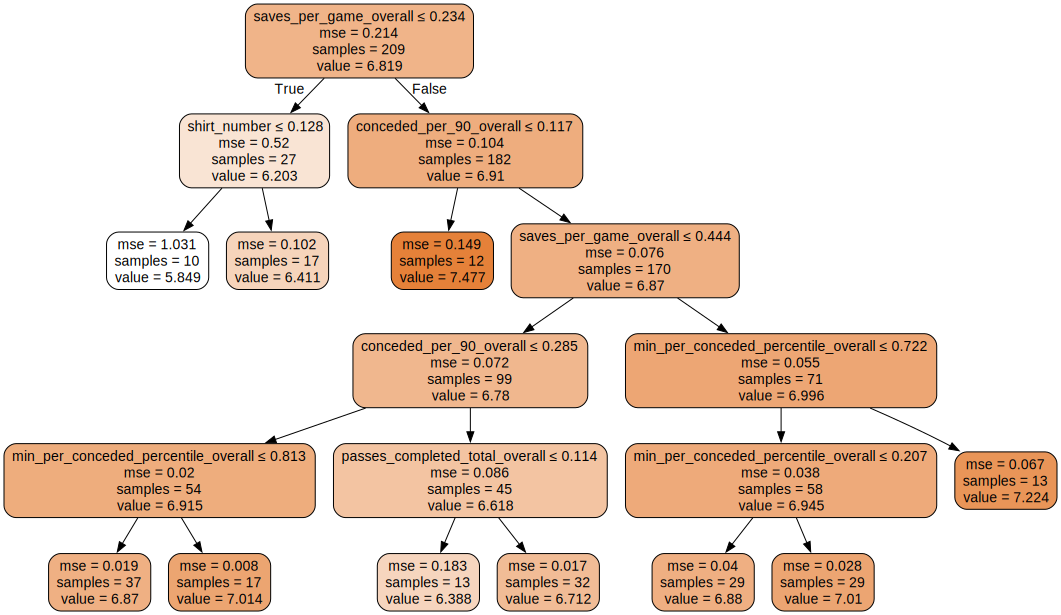

In [59]:
best_dt_model_1 = dt_model_cv_1.best_estimator_

draw_tree(best_dt_model_1, labels_1, filename = "dt_goalkeeper")

In [60]:


feature_importances_dt_1 = best_dt_model_1.feature_importances_
top_feature_dt_1 = print_feature_importance_tree(feature_importances_dt_1, labels_1)



Top 5 Feature Importances:
1. saves_per_game_overall: 0.5642466769963773
2. conceded_per_90_overall: 0.25974133623797885
3. shirt_number: 0.08202406637581422
4. min_per_conceded_percentile_overall: 0.054017972276024805
5. passes_completed_total_overall: 0.039969948113804825

Bottom 5 Feature Importances:
1. three_goals_in_a_game_total_overall: 0.0
2. goals_involved_per90_percentile_overall: 0.0
3. annual_salary_eur: 0.0
4. cards_per90_percentile_overall: 0.0
5. booked_over05_percentage_overall: 0.0


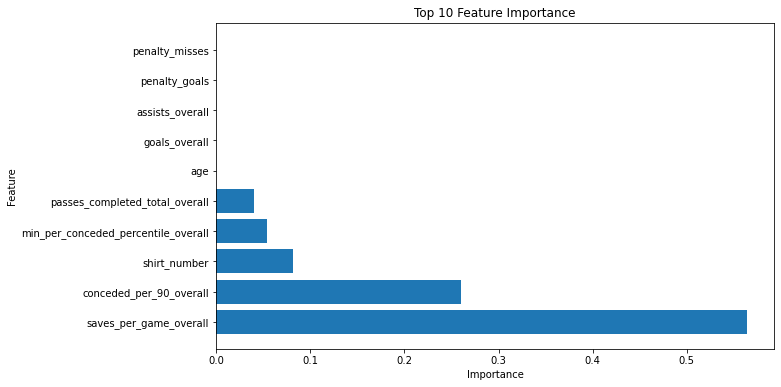

In [61]:
plot_feature_importance_tree(feature_importances_dt_1, labels_1)

#### We now use an ensembling method (Random Forest) to mitigate overfitting:

Without Cross Validation

In [62]:
rf_model_1, mse_rf_1_noncv = train_tree_regressors(X_train_scaled_1, y_train_1, X_test_scaled_1, y_test_1,
                                 algorithm = "rf_reg", cross_validation = False, max_depth = 5, min_samples_leaf = 5)


Mean Squared Error (MSE) - Random Forest : 0.06019166227996984
Mean Absolute Error (MAE) - Random Forest : 0.1504743508031809


With Cross Validation

In [63]:
rf_model_cv_1, mse_rf_1 = train_tree_regressors(X_train_scaled_1, y_train_1, X_test_scaled_1, y_test_1,
                                 algorithm = "rf_reg", cross_validation = True)
mse_list_1.append(mse_rf_1)

Best Parameters for Random Forest: {'max_depth': 9, 'min_samples_leaf': 5}
Mean Squared Error (MSE) - Random Forest CV: 0.05796053827003946
Mean Absolute Error (MAE) - Random Forest CV: 0.14474917779636667


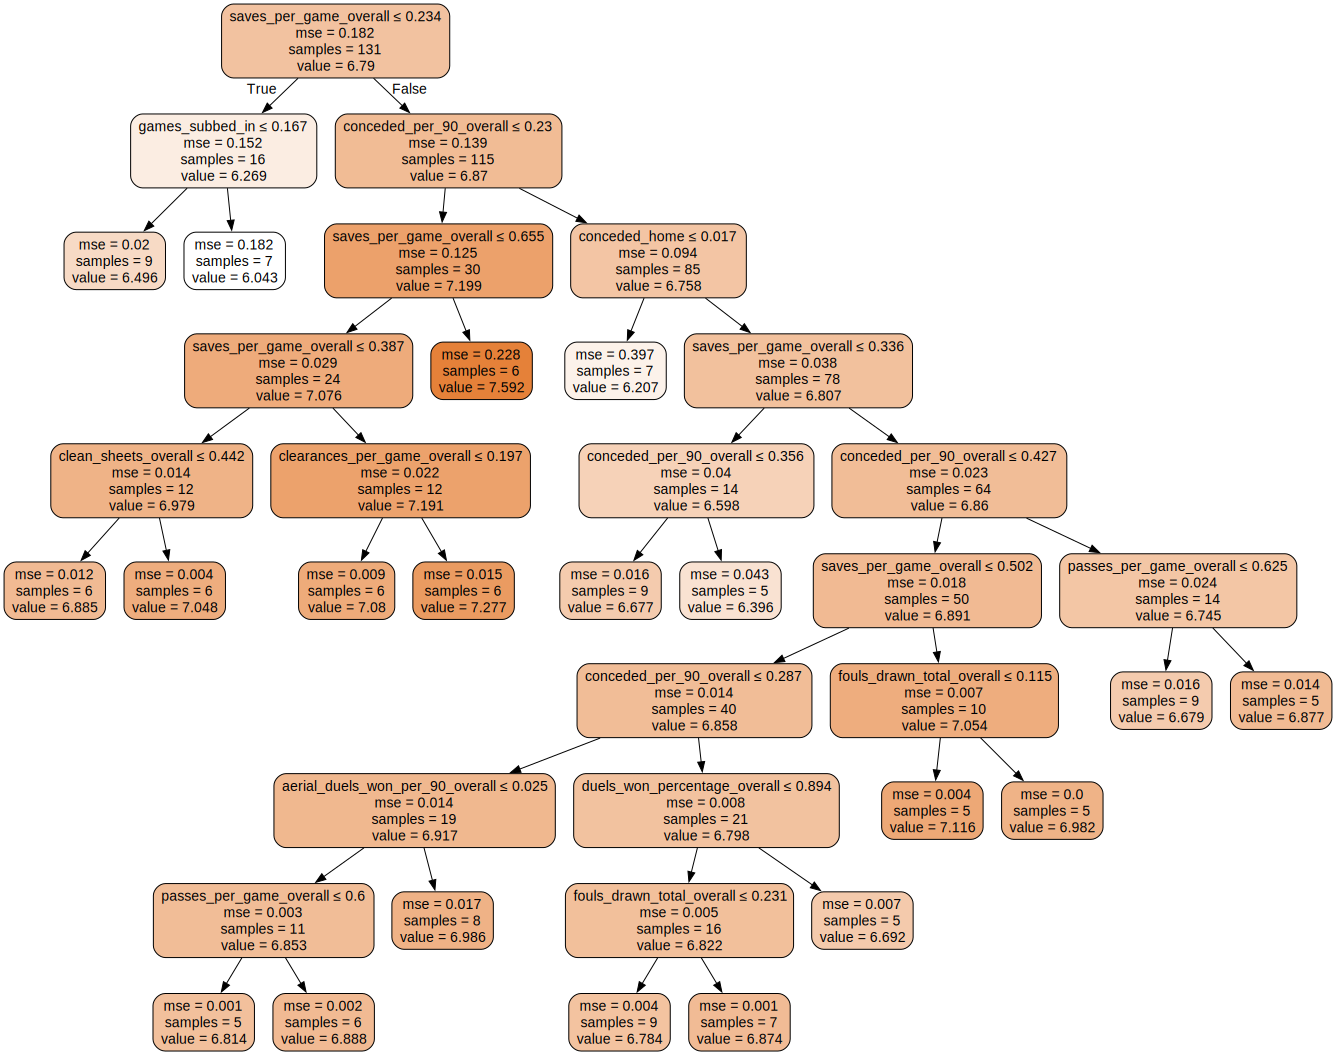

In [64]:
#We visualise one tree (the last one for example)

best_rf_model_1 = rf_model_cv_1.best_estimator_


tree_in_forest = best_rf_model_1.estimators_[-1]

draw_tree(tree_in_forest, labels_1, filename = "rf_goalkeeper")

In [65]:
importancesrf_1 = best_rf_model_1.feature_importances_
top_feature_rf_1 = print_feature_importance_tree(importancesrf_1, labels_1)

Top 5 Feature Importances:
1. saves_per_game_overall: 0.5232488828283002
2. conceded_per_90_overall: 0.21941114771783565
3. passes_per_game_overall: 0.04684800860407643
4. min_per_conceded_percentile_overall: 0.026332325265966298
5. passes_completed_total_overall: 0.02307055494822734

Bottom 5 Feature Importances:
1. distance_travelled_per90_percentile_overall: 0.0
2. accurate_crosses_per_90_overall: 0.0
3. hattricks_total_overall: 0.0
4. two_goals_in_a_game_total_overall: 0.0
5. three_goals_in_a_game_total_overall: 0.0


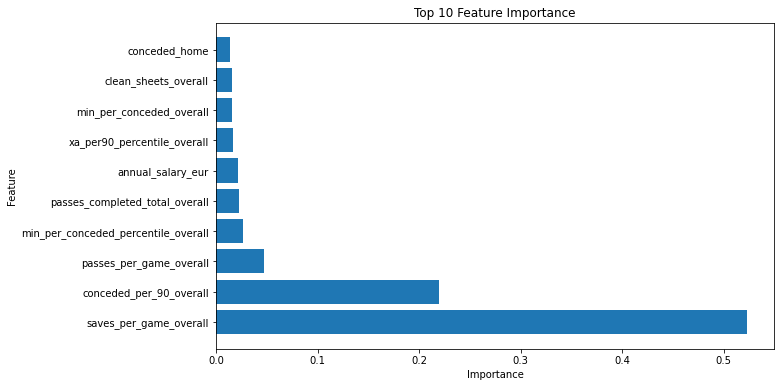

In [66]:
# Calculate feature importances

plot_feature_importance_tree(importancesrf_1, labels_1)

###Gradient Boosting Regressor (XGBoost)

With Cross-Validation

In [67]:
XGB_model_cv_1, mse_xgb_1 = train_tree_regressors(X_train_scaled_1, y_train_1, X_test_scaled_1, y_test_1,
                          algorithm = "XGB_reg")

mse_list_1.append(mse_xgb_1)

Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 7}
Mean Squared Error (MSE) - XGBoost CV: 0.06008417847112378
Mean Absolute Error (MAE) - XGBoost CV: 0.1480690751756941


Without Cross-Validation

In [68]:
XGB_model_1, xgb_mse_1_noncv = train_tree_regressors(X_train_scaled_1, y_train_1, X_test_scaled_1, y_test_1,
                          algorithm = "XGB_reg", cross_validation = False)

Mean Squared Error (MSE) - XGBoost : 0.06330750474239968
Mean Absolute Error (MAE) - XGBoost : 0.15289306340898795


In [98]:
importancesxgb_1 = XGB_model_cv_1.best_estimator_.feature_importances_
top_feature_xgb_1 = print_feature_importance_tree(importancesxgb_1, labels_1)


Top 5 Feature Importances:
1. cards_per_90_overall: 0.2317693680524826
2. saves_per_game_overall: 0.19132599234580994
3. conceded_per_90_overall: 0.09314243495464325
4. min_per_conceded_percentile_overall: 0.058747388422489166
5. tackles_per_game_overall: 0.05799045413732529

Bottom 5 Feature Importances:
1. accurate_crosses_per_90_overall: 0.0
2. accurate_crosses_per90_percentile_overall: 0.0
3. hattricks_total_overall: 0.0
4. two_goals_in_a_game_total_overall: 0.0
5. three_goals_in_a_game_total_overall: 0.0


### Plot

In [70]:
features_1.append(top_feature_dt_1)
features_1.append(top_feature_rf_1)
features_1.append(top_feature_xgb_1)

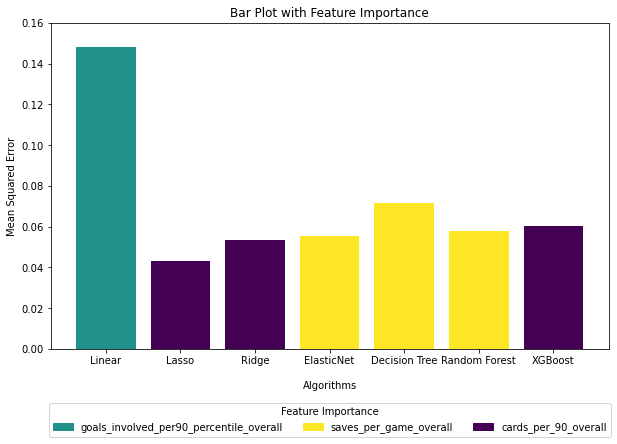

In [118]:
plot_and_save(algorithms, mse_list_1, features_1, filename = "plot_1.png", ylim = 0.16)

## Case 2: Defenders

In [119]:
# Global variables for the final plot

algorithms = ["Linear", "Lasso", "Ridge", "ElasticNet", "Decision Tree", "Random Forest", "XGBoost"]
mse_list_2 = []
features_2 = []

### Regressions

#### Linear regression

In [120]:
linear_regression_2, mse_linear_2 = train_regressions(X_train_scaled_2, y_train_2, X_test_scaled_2, y_test_2, algorithm = "linear_reg")

mse_list_2.append(mse_linear_2)

Mean Squared Error (MSE) - Linear Regression: 0.2593653903619756
Mean Absolute Error (MAE) -  Linear Regression: 0.28298576820206756


#### Lasso regression (L1 norm)

Without cross validation

In [121]:
lasso_model_2, mse_lasso_2_noncv = train_regressions(X_train_scaled_2, y_train_2, X_test_scaled_2, y_test_2,
                          algorithm = "lasso_reg", cross_validation = False, alpha = 0.1)

Mean Squared Error (MSE) - Lasso Regression : 0.4929084115514
Mean Absolute Error (MAE) - Lasso Regression : 0.4043908728681014


With cross validation

In [122]:
lasso_model_cv_2, mse_lasso_2 = train_regressions(X_train_scaled_2, y_train_2, X_test_scaled_2, y_test_2,
                          algorithm = "lasso_reg", cross_validation = True)

mse_list_2.append(mse_lasso_2)

Best alpha for Lasso regression: 0.001
Mean Squared Error (MSE) - Lasso Regression CV: 0.2577271464614904
Mean Absolute Error (MAE) - Lasso Regression CV: 0.27990782690126287


#### Ridge regression (L2 norm)

Without cross validation

In [123]:
ridge_model_2, mse_ridge_2_noncv = train_regressions(X_train_scaled_2, y_train_2, X_test_scaled_2, y_test_2,
                          algorithm = "ridge_reg", cross_validation = False, alpha = 0.1)

Mean Squared Error (MSE) - Ridge Regression : 0.25204420870295297
Mean Absolute Error (MAE) - Ridge Regression : 0.2755679071742153


With cross validation

In [124]:
ridge_model_cv_2, mse_ridge_2 = train_regressions(X_train_scaled_2, y_train_2, X_test_scaled_2, y_test_2,
                          algorithm = "ridge_reg", cross_validation = True)

mse_list_2.append(mse_ridge_2)

Best alpha for Ridge regression: 10.0
Mean Squared Error (MSE) - Ridge Regression CV: 0.2724733622796758
Mean Absolute Error (MAE) - Ridge Regression CV: 0.28643398671519216


#### We also look at ElasticNet, which combines Lasso and Ridge :

Without cross validation

In [125]:
elasticNet_model_2, mse_enet_2_noncv = train_regressions(X_train_scaled_2, y_train_2, X_test_scaled_2, y_test_2,
                         algorithm = "elasticnet_reg", cross_validation = False, alpha = 0.1, l1_ratio = 0.5)

Mean Squared Error (MSE) - ElasticNet : 0.4551047581756352
Mean Absolute Error (MAE) - ElasticNet : 0.3815122525818028


With cross validation

In [126]:
elasticNet_model_cv_2, mse_enet_2 = train_regressions(X_train_scaled_2, y_train_2, X_test_scaled_2, y_test_2,
                         algorithm = "elasticnet_reg", cross_validation = True)

mse_list_2.append(mse_enet_2)

Best Hyperparameters for ElasticNet: {'alpha': 0.01, 'l1_ratio': 0.1, 'max_iter': 100}
Mean Squared Error (MSE) - ElasticNet CV: 0.27253767052827826
Mean Absolute Error (MAE) - ElasticNet CV: 0.28746088735380004


In [127]:
elasticNet_model_cv_2.best_params_

{'alpha': 0.01, 'l1_ratio': 0.1, 'max_iter': 100}

### Feature importance for regressions

In [128]:
features_dict_2 = print_feature_importance_reg(position_2_data,linear_regression_2, lasso_model_cv_2, ridge_model_cv_2, elasticNet_model_cv_2, cv = True, top = 3, bottom = 3)

features_2 = list(features_dict_2.values())


Variable Importance - Linear Regression:
1. chances_created_per90_percentile_overall: 9996140990682.4
2. possession_regained_per90_percentile_overall: 3692257628539.5146
3. long_passes_per90_percentile_overall: 3117876710930.564
...
84. penalties_won_total_overall: 0.015178680419921875
85. assists_overall: 0.0017391002404376077
86. distance_travelled_per90_percentile_overall: 0.0

Variable Importance - Lasso Regression:
1. conceded_per_90_overall: 1.6393305492304384
2. aerial_duels_won_per_90_overall: 1.3327451427816226
3. passes_per_game_overall: 0.8761901071980561
...
84. shots_off_target_per_90_overall: 0.0
85. shots_on_target_per_90_overall: 0.0
86. age: 0.0

Variable Importance - Ridge Regression:
1. passes_per_game_overall: 0.5713093319941344
2. conceded_per_90_overall: 0.545295019605653
3. interceptions_per_game_overall: 0.40622459619462303
...
84. through_passes_per90_percentile_overall: 0.0
85. tackles_successful_per90_percentile_overall: 0.0
86. possession_regained_total_ove

### Tree Algorithms

#### Decision Tree Regressor:

Without Cross Validation

In [129]:
dt_model_2, mse_dt_2_noncv = train_tree_regressors(X_train_scaled_2, y_train_2, X_test_scaled_2, y_test_2,
                                 algorithm = "dt_reg", cross_validation = False, max_depth = 5, min_samples_leaf = 5)


Mean Squared Error (MSE) - Decision Tree : 0.2211749577617562
Mean Absolute Error (MAE) - Decision Tree : 0.2774883192278605


With Cross Validation

In [130]:
dt_model_cv_2, mse_dt_2 = train_tree_regressors(X_train_scaled_2, y_train_2, X_test_scaled_2, y_test_2,
                                 algorithm = "dt_reg", cross_validation = True)

mse_list_2.append(mse_dt_2)


Best Parameters for Decision Tree: {'max_depth': 5, 'min_samples_leaf': 15}
Mean Squared Error (MSE) - Decision Tree CV: 0.21672159828868473
Mean Absolute Error (MAE) - Decision Tree CV: 0.2850235071100393


In [131]:
labels_2 = position_2_data.drop(columns=["position","average_rating_overall"]).columns

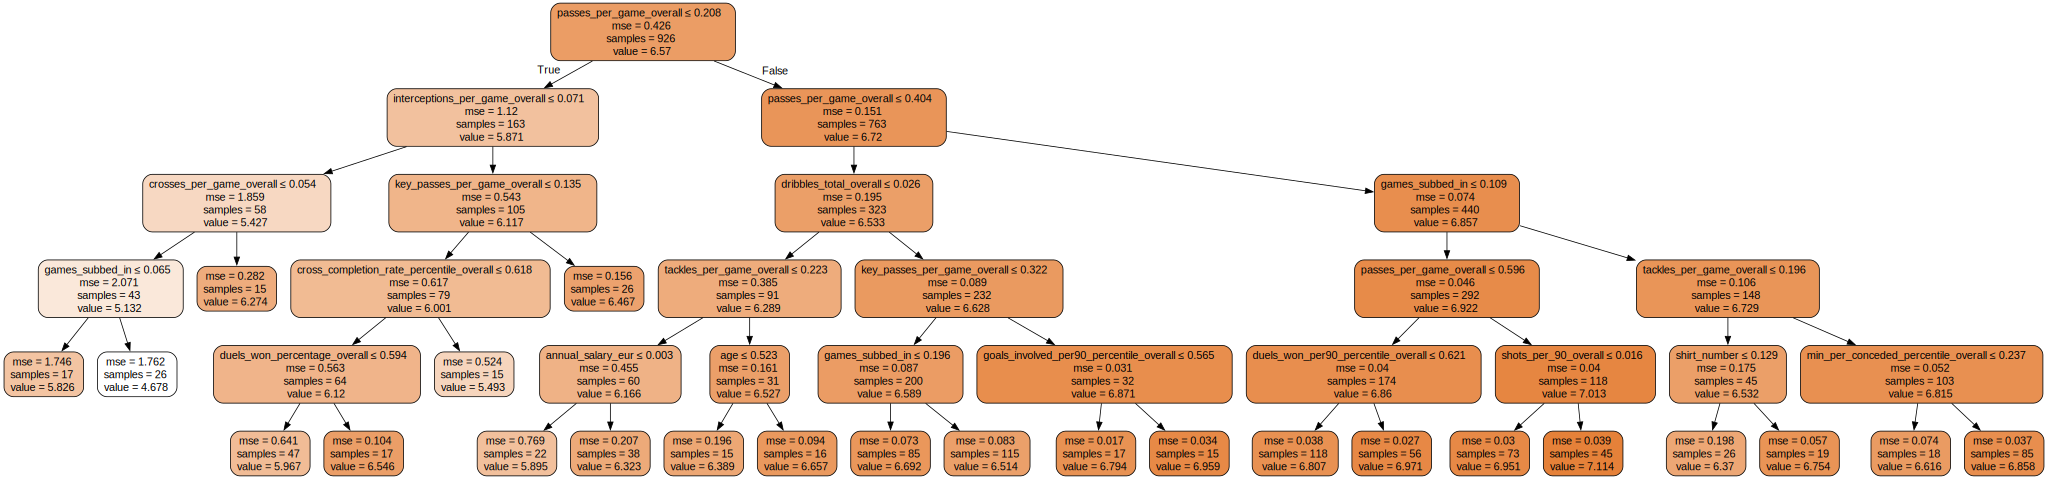

In [132]:
best_dt_model_2 = dt_model_cv_2.best_estimator_

draw_tree(best_dt_model_2, labels_2, filename = "dt_defender")

In [133]:
feature_importances_dt_2 = best_dt_model_2.feature_importances_
feature_names = labels_2

top_feature_dt_2 = print_feature_importance_tree(feature_importances_dt_2, labels_2)

Top 5 Feature Importances:
1. passes_per_game_overall: 0.5761816299411442
2. games_subbed_in: 0.09160324206577003
3. interceptions_per_game_overall: 0.08682005057646547
4. crosses_per_game_overall: 0.0709162279999381
5. dribbles_total_overall: 0.036800658882961274

Bottom 5 Feature Importances:
1. hattricks_total_overall: 0.0
2. two_goals_in_a_game_total_overall: 0.0
3. three_goals_in_a_game_total_overall: 0.0
4. cards_per90_percentile_overall: 0.0
5. booked_over05_percentage_overall: 0.0


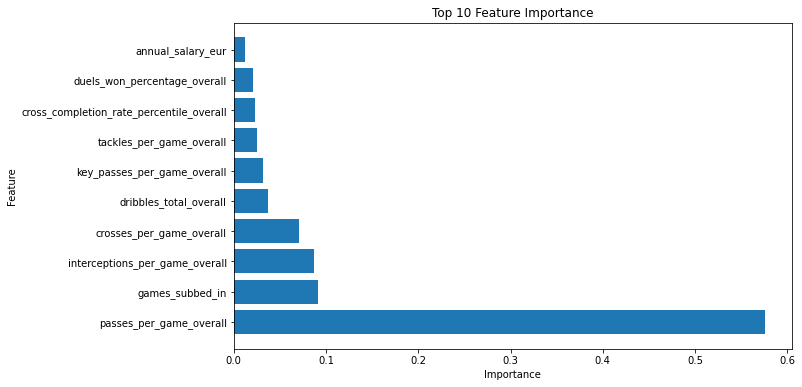

In [134]:
plot_feature_importance_tree(feature_importances_dt_2, labels_2)

#### We now use an ensembling method (Random Forest) to mitigate overfitting:

Without Cross Validation

In [135]:
rf_model_2, mse_rf_2_noncv = train_tree_regressors(X_train_scaled_2, y_train_2, X_test_scaled_2, y_test_2,
                                 algorithm = "rf_reg", cross_validation = False, max_depth = 5, min_samples_leaf = 5)


Mean Squared Error (MSE) - Random Forest : 0.27413220223158946
Mean Absolute Error (MAE) - Random Forest : 0.28770883019575194


With Cross Validation

In [136]:
rf_model_cv_2, mse_rf_2 = train_tree_regressors(X_train_scaled_2, y_train_2, X_test_scaled_2, y_test_2,
                                 algorithm = "rf_reg", cross_validation = True)

mse_list_2.append(mse_rf_2)

Best Parameters for Random Forest: {'max_depth': 9, 'min_samples_leaf': 10}
Mean Squared Error (MSE) - Random Forest CV: 0.2612110282667802
Mean Absolute Error (MAE) - Random Forest CV: 0.28149527878859704


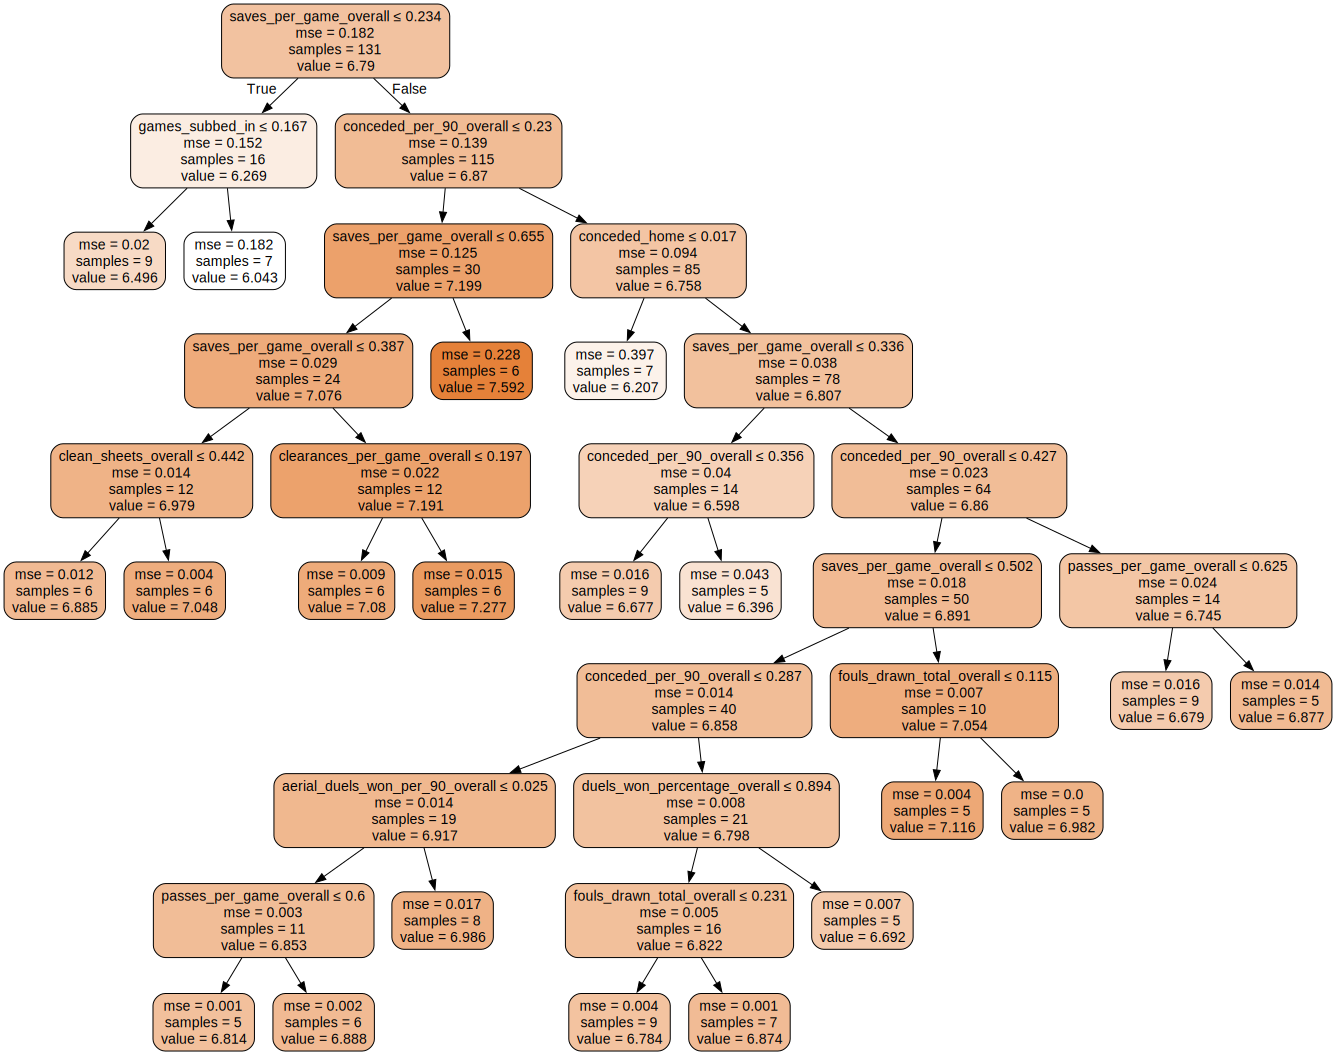

In [137]:
best_rf_model_2 = rf_model_cv_1.best_estimator_


tree_in_forest = best_rf_model_2.estimators_[-1]

draw_tree(tree_in_forest, labels_2, filename = "rf_defender")

In [138]:
importancesrf_2 = best_rf_model_2.feature_importances_
top_feature_rf_2 = print_feature_importance_tree(importancesrf_2, labels_2)

Top 5 Feature Importances:
1. saves_per_game_overall: 0.5232488828283002
2. conceded_per_90_overall: 0.21941114771783565
3. passes_per_game_overall: 0.04684800860407643
4. min_per_conceded_percentile_overall: 0.026332325265966298
5. passes_completed_total_overall: 0.02307055494822734

Bottom 5 Feature Importances:
1. distance_travelled_per90_percentile_overall: 0.0
2. accurate_crosses_per_90_overall: 0.0
3. hattricks_total_overall: 0.0
4. two_goals_in_a_game_total_overall: 0.0
5. three_goals_in_a_game_total_overall: 0.0


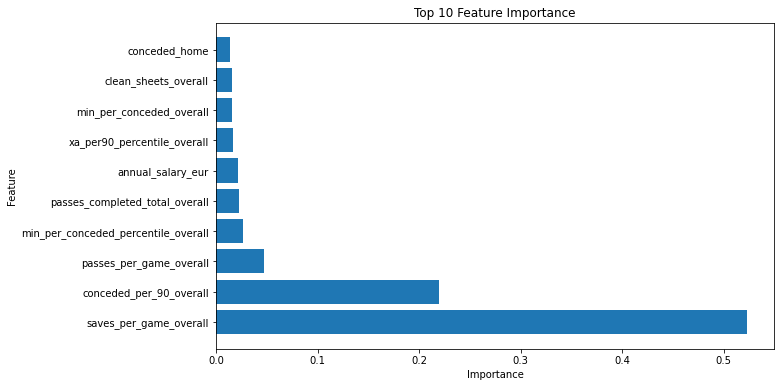

In [139]:
# Calculate feature importances

plot_feature_importance_tree(importancesrf_2, labels_2)

###Gradient Boosting Regressor (XGBoost)

With Cross-Validation

In [140]:
XGB_model_cv_2, mse_xgb_2 = train_tree_regressors(X_train_scaled_2, y_train_2, X_test_scaled_2, y_test_2,
                          algorithm = "XGB_reg")

mse_list_2.append(mse_xgb_2)

Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5}
Mean Squared Error (MSE) - XGBoost CV: 0.25268922420471024
Mean Absolute Error (MAE) - XGBoost CV: 0.27773284316062924


Without Cross-Validation

In [141]:
XGB_model_2, xgb_mse_2_noncv = train_tree_regressors(X_train_scaled_2, y_train_2, X_test_scaled_2, y_test_2,
                          algorithm = "XGB_reg", cross_validation = False)

Mean Squared Error (MSE) - XGBoost : 0.26652746528351234
Mean Absolute Error (MAE) - XGBoost : 0.2863734061964626


In [142]:
importancesxgb_2 = XGB_model_cv_2.best_estimator_.feature_importances_
top_feature_xgb_2 = print_feature_importance_tree(importancesxgb_2, labels_2)


Top 5 Feature Importances:
1. passes_per_game_overall: 0.09585490822792053
2. duels_per_game_overall: 0.09391028434038162
3. dribbles_total_overall: 0.05650161951780319
4. fouls_committed_total_overall: 0.04095905274152756
5. crosses_per_game_overall: 0.04059986770153046

Bottom 5 Feature Importances:
1. dispossesed_total_overall: 0.0
2. distance_travelled_per90_percentile_overall: 0.0
3. hattricks_total_overall: 0.0
4. two_goals_in_a_game_total_overall: 0.0
5. three_goals_in_a_game_total_overall: 0.0


### Plot

In [143]:
features_2.append(top_feature_dt_2)
features_2.append(top_feature_rf_2)
features_2.append(top_feature_xgb_2)

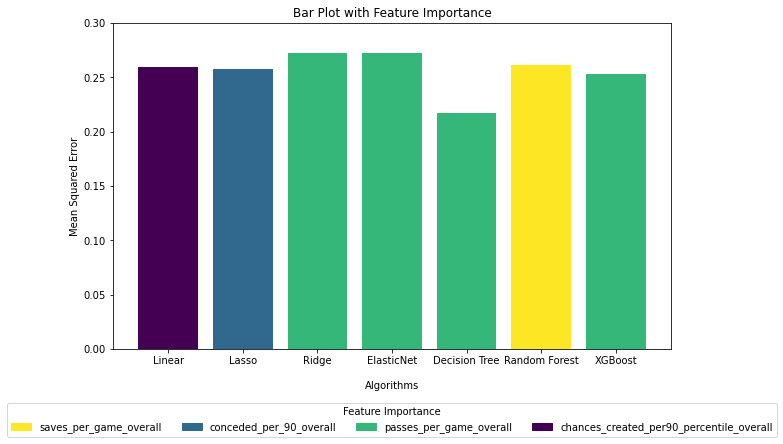

In [145]:
plot_and_save(algorithms, mse_list_2, features_2, filename = "plot_2.png", ylim = 0.3)

## Case 3: Midfielders

In [179]:
# Global variables for the final plot

algorithms = ["Linear", "Lasso", "Ridge", "ElasticNet", "Decision Tree", "Random Forest", "XGBoost"]
mse_list_3 = []
features_3 = []

### Regressions

#### Linear regression

In [180]:
linear_regression_3, mse_linear_3 = train_regressions(X_train_scaled_3, y_train_3, X_test_scaled_3, y_test_3, algorithm = "linear_reg")

mse_list_3.append(mse_linear_3)

Mean Squared Error (MSE) - Linear Regression: 0.33710367402658153
Mean Absolute Error (MAE) -  Linear Regression: 0.34424116124127063


#### Lasso regression (L1 norm)

Without cross validation

In [181]:
lasso_model_3, mse_lasso_3_noncv = train_regressions(X_train_scaled_3, y_train_3, X_test_scaled_3, y_test_3,
                          algorithm = "lasso_reg", cross_validation = False, alpha = 0.1)

Mean Squared Error (MSE) - Lasso Regression : 0.4799601048662422
Mean Absolute Error (MAE) - Lasso Regression : 0.40735545967474257


With cross validation

In [182]:
lasso_model_cv_3, mse_lasso_3 = train_regressions(X_train_scaled_3, y_train_3, X_test_scaled_3, y_test_3,
                          algorithm = "lasso_reg", cross_validation = True)

mse_list_3.append(mse_lasso_3)

Best alpha for Lasso regression: 0.001
Mean Squared Error (MSE) - Lasso Regression CV: 0.3176666133202331
Mean Absolute Error (MAE) - Lasso Regression CV: 0.3238698523822592


#### Ridge regression (L2 norm)

Without cross validation

In [183]:
ridge_model_3, mse_ridge_3_noncv = train_regressions(X_train_scaled_3, y_train_3, X_test_scaled_3, y_test_3,
                          algorithm = "ridge_reg", cross_validation = False, alpha = 0.1)

Mean Squared Error (MSE) - Ridge Regression : 0.3342574436269264
Mean Absolute Error (MAE) - Ridge Regression : 0.3413120972396519


With cross validation

In [184]:
ridge_model_cv_3, mse_ridge_3 = train_regressions(X_train_scaled_3, y_train_3, X_test_scaled_3, y_test_3,
                          algorithm = "ridge_reg", cross_validation = True)

mse_list_3.append(mse_ridge_3)

Best alpha for Ridge regression: 10.0
Mean Squared Error (MSE) - Ridge Regression CV: 0.317203357667946
Mean Absolute Error (MAE) - Ridge Regression CV: 0.32420417793094475


#### We also look at ElasticNet, which combines Lasso and Ridge :

Without cross validation

In [185]:
elasticNet_model_3, mse_enet_3_noncv = train_regressions(X_train_scaled_3, y_train_3, X_test_scaled_3, y_test_3,
                         algorithm = "elasticnet_reg", cross_validation = False, alpha = 0.1, l1_ratio = 0.5)


Mean Squared Error (MSE) - ElasticNet : 0.4531015771548153
Mean Absolute Error (MAE) - ElasticNet : 0.39263208719311954


With cross validation

In [186]:
elasticNet_model_cv_3, mse_enet_3 = train_regressions(X_train_scaled_3, y_train_3, X_test_scaled_3, y_test_3,
                         algorithm = "elasticnet_reg", cross_validation = True)

mse_list_3.append(mse_enet_3)

Best Hyperparameters for ElasticNet: {'alpha': 0.01, 'l1_ratio': 0.1, 'max_iter': 100}
Mean Squared Error (MSE) - ElasticNet CV: 0.31661522026524325
Mean Absolute Error (MAE) - ElasticNet CV: 0.3234265746462647


In [187]:
elasticNet_model_cv_3.best_params_

{'alpha': 0.01, 'l1_ratio': 0.1, 'max_iter': 100}

### Feature importance for regressions

In [188]:
features_dict_3 = print_feature_importance_reg(position_3_data,linear_regression_3, lasso_model_cv_3, ridge_model_cv_3, elasticNet_model_cv_3, cv = True, top = 3, bottom = 3)

features_3 = list(features_dict_3.values())


Variable Importance - Linear Regression:
1. shots_on_target_per_90_overall: 12.21303599532193
2. shots_per_90_overall: 11.878003653172943
3. shots_off_target_per_90_overall: 9.742075111020606
...
84. market_value: 2.220446049250313e-16
85. through_passes_per90_percentile_overall: 0.0
86. distance_travelled_per90_percentile_overall: 0.0

Variable Importance - Lasso Regression:
1. key_passes_per_game_overall: 1.4459619761827083
2. cards_per_90_overall: 0.9254760395459211
3. shots_on_target_per_90_overall: 0.9219869625246686
...
84. dispossesed_per_90_overall: 0.0
85. shots_per_90_overall: 0.0
86. distance_travelled_per90_percentile_overall: 0.0

Variable Importance - Ridge Regression:
1. key_passes_per_game_overall: 0.4639219541871902
2. tackles_per_game_overall: 0.4620713439518425
3. passes_per_game_overall: 0.45551511622629004
...
84. tackles_successful_per90_percentile_overall: 0.0
85. saves_per_game_overall: 0.0
86. possession_regained_total_overall: 0.0

Variable Importance - Elast

### Tree Algorithms

#### Decision Tree Regressor:

Without Cross Validation

In [189]:
dt_model_3, mse_dt_3_noncv = train_tree_regressors(X_train_scaled_3, y_train_3, X_test_scaled_3, y_test_3,
                                 algorithm = "dt_reg", cross_validation = False, max_depth = 5, min_samples_leaf = 5)


Mean Squared Error (MSE) - Decision Tree : 0.3779300935965931
Mean Absolute Error (MAE) - Decision Tree : 0.34574253090989093


With Cross Validation

In [190]:
dt_model_cv_3, mse_dt_3 = train_tree_regressors(X_train_scaled_3, y_train_3, X_test_scaled_3, y_test_3,
                                 algorithm = "dt_reg", cross_validation = True)
mse_list_3.append(mse_dt_3)

Best Parameters for Decision Tree: {'max_depth': 7, 'min_samples_leaf': 15}
Mean Squared Error (MSE) - Decision Tree CV: 0.4333981803579322
Mean Absolute Error (MAE) - Decision Tree CV: 0.3715199479989672


In [191]:
labels_3 = position_3_data.drop(columns=["position","average_rating_overall"]).columns

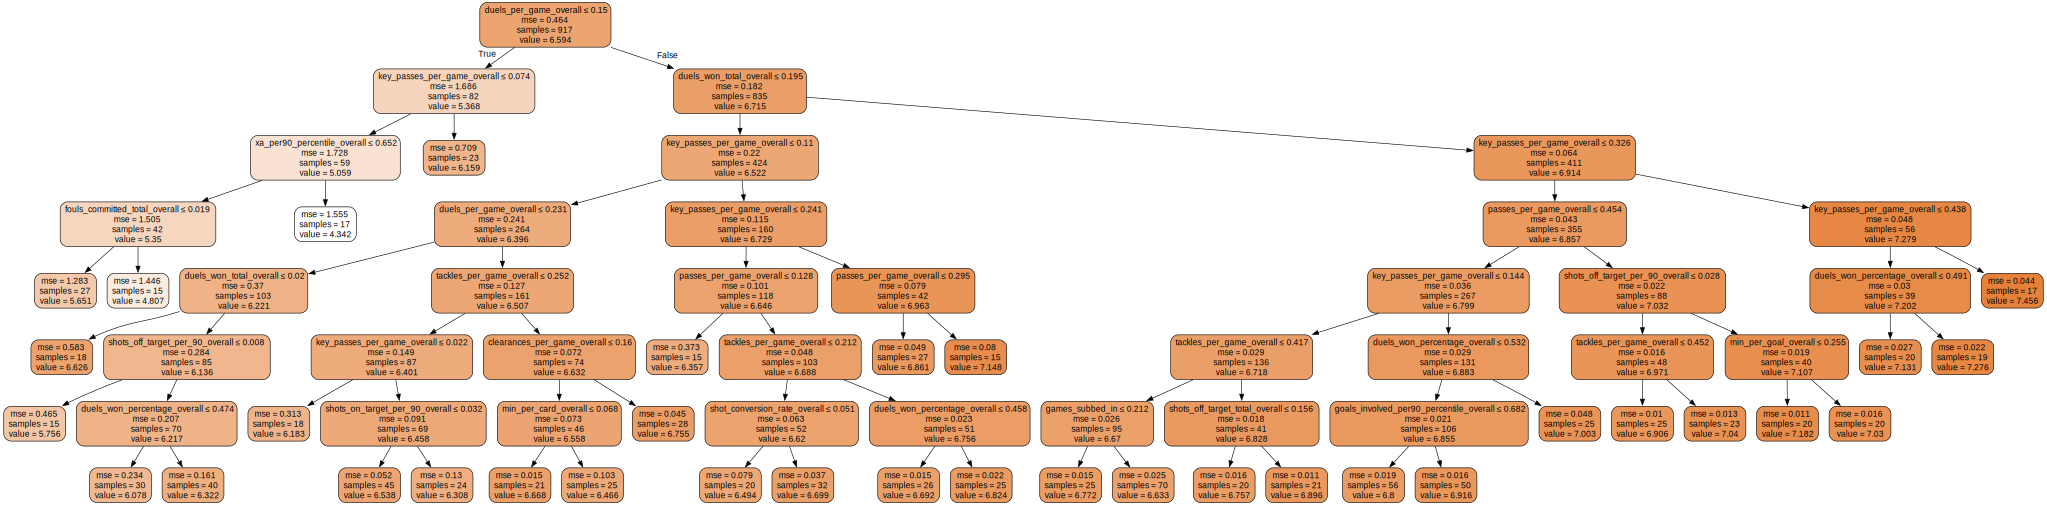

In [192]:
best_dt_model_3 = dt_model_cv_3.best_estimator_
draw_tree(best_dt_model_3, labels_3, filename = "dt_midfielder")

In [193]:
feature_importances_dt_3 = best_dt_model_3.feature_importances_
feature_names = labels_3

top_feature_dt_3 = print_feature_importance_tree(feature_importances_dt_3, labels_3)

Top 5 Feature Importances:
1. duels_per_game_overall: 0.5410303330674
2. key_passes_per_game_overall: 0.17877153776419552
3. duels_won_total_overall: 0.13750634978977183
4. xa_per90_percentile_overall: 0.04729961023920844
5. fouls_committed_total_overall: 0.026409161411132503

Bottom 5 Feature Importances:
1. three_goals_in_a_game_total_overall: 0.0
2. annual_salary_eur: 0.0
3. cards_per90_percentile_overall: 0.0
4. booked_over05_percentage_overall: 0.0
5. shirt_number: 0.0


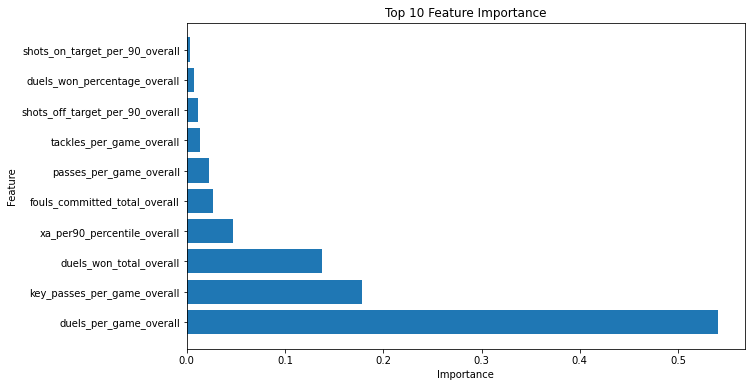

In [194]:
plot_feature_importance_tree(feature_importances_dt_3, labels_3)

#### We now use an ensembling method (Random Forest) to mitigate overfitting:

Without Cross Validation

In [195]:
rf_model_3, mse_rf_3_noncv = train_tree_regressors(X_train_scaled_3, y_train_3, X_test_scaled_3, y_test_3,
                                 algorithm = "rf_reg", cross_validation = False, max_depth = 5, min_samples_leaf = 5)


Mean Squared Error (MSE) - Random Forest : 0.3000438846446913
Mean Absolute Error (MAE) - Random Forest : 0.3075639770736071


With Cross Validation

In [196]:
rf_model_cv_3, mse_rf_3 = train_tree_regressors(X_train_scaled_3, y_train_3, X_test_scaled_3, y_test_3,
                                 algorithm = "rf_reg", cross_validation = True)
mse_list_3.append(mse_rf_3)

Best Parameters for Random Forest: {'max_depth': 9, 'min_samples_leaf': 5}
Mean Squared Error (MSE) - Random Forest CV: 0.2945477187444116
Mean Absolute Error (MAE) - Random Forest CV: 0.30446631902277344


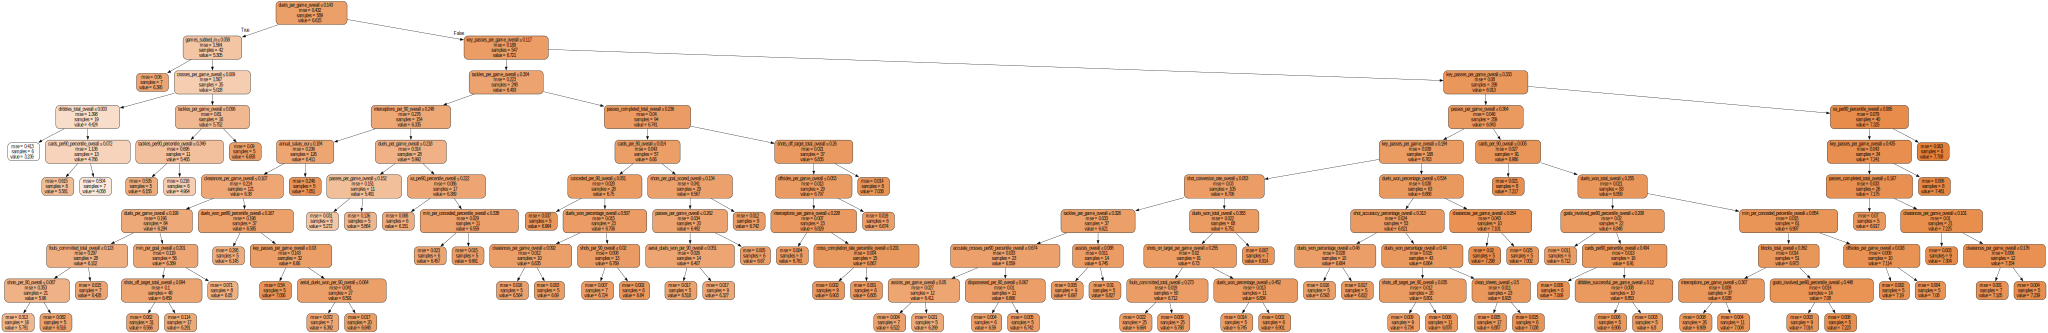

In [197]:
#We visualise one tree (the last one for example)

best_rf_model_3 = rf_model_cv_3.best_estimator_


tree_in_forest = best_rf_model_3.estimators_[-1]

draw_tree(tree_in_forest, labels_3, filename = "rf_midfielder")

In [198]:
importancesrf_3 = best_rf_model_3.feature_importances_
top_feature_rf_3 = print_feature_importance_tree(importancesrf_3, labels_3)

Top 5 Feature Importances:
1. duels_per_game_overall: 0.4296025935972833
2. key_passes_per_game_overall: 0.10460053468233066
3. passes_per_game_overall: 0.05363482248547818
4. duels_won_total_overall: 0.04878429619712415
5. duels_won_per90_percentile_overall: 0.027112809604537547

Bottom 5 Feature Importances:
1. pens_saved_total_overall: 0.0
2. punches_per_game_overall: 0.0
3. distance_travelled_per90_percentile_overall: 0.0
4. hattricks_total_overall: 0.0
5. three_goals_in_a_game_total_overall: 0.0


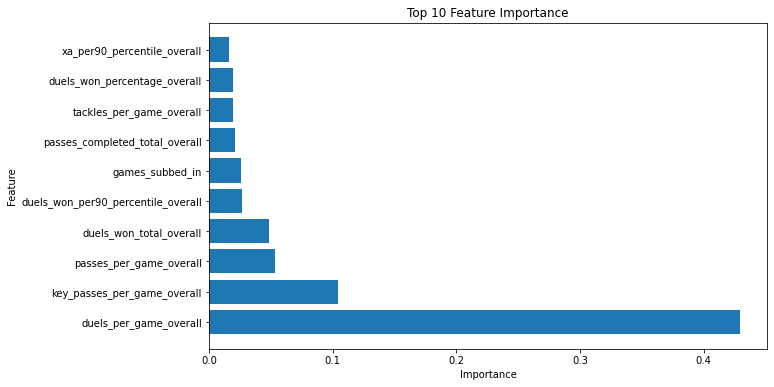

In [199]:
# Calculate feature importances

plot_feature_importance_tree(importancesrf_3, labels_3)

###Gradient Boosting Regressor (XGBoost)

With Cross-Validation

In [200]:
XGB_model_cv_3, mse_xgb_3 = train_tree_regressors(X_train_scaled_3, y_train_3, X_test_scaled_3, y_test_3,
                          algorithm = "XGB_reg")

mse_list_3.append(mse_xgb_3)

Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 7}
Mean Squared Error (MSE) - XGBoost CV: 0.3450934413964778
Mean Absolute Error (MAE) - XGBoost CV: 0.3132154178204744


Without Cross-Validation

In [201]:
XGB_model_3, xgb_mse_3_noncv = train_tree_regressors(X_train_scaled_3, y_train_3, X_test_scaled_3, y_test_3,
                          algorithm = "XGB_reg", cross_validation = False)

Mean Squared Error (MSE) - XGBoost : 0.3365020229984046
Mean Absolute Error (MAE) - XGBoost : 0.3126197875478994


In [202]:
importancesxgb_3 = XGB_model_cv_3.best_estimator_.feature_importances_
top_feature_xgb_3 = print_feature_importance_tree(importancesxgb_3, labels_3)


Top 5 Feature Importances:
1. duels_per_game_overall: 0.2433883398771286
2. duels_won_total_overall: 0.1440386325120926
3. shots_off_target_total_overall: 0.0706576257944107
4. key_passes_per_game_overall: 0.057714223861694336
5. games_subbed_in: 0.03769698366522789

Bottom 5 Feature Importances:
1. pens_saved_total_overall: 0.0
2. punches_per_game_overall: 0.0
3. distance_travelled_per90_percentile_overall: 0.0
4. hattricks_total_overall: 0.0
5. three_goals_in_a_game_total_overall: 0.0


#### Plot

In [203]:
features_3.append(top_feature_dt_3)
features_3.append(top_feature_rf_3)
features_3.append(top_feature_xgb_3)

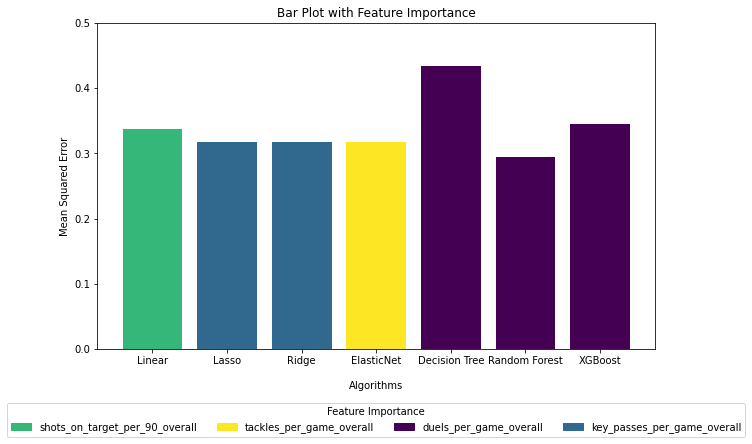

In [205]:
plot_and_save(algorithms, mse_list_3, features_3, filename = "plot_3.png", ylim = 0.5)

## Case 4: Forwards (attackers)

In [235]:
# Global variables for the final plot

algorithms = ["Linear", "Lasso", "Ridge", "ElasticNet", "Decision Tree", "Random Forest", "XGBoost"]
mse_list_4 = []
features_4 = []

### Regressions

#### Linear regression

In [236]:
linear_regression_4, mse_linear_4 = train_regressions(X_train_scaled_4, y_train_4, X_test_scaled_4, y_test_4, algorithm = "linear_reg")

mse_list_4.append(mse_linear_4)

Mean Squared Error (MSE) - Linear Regression: 0.2841266801132286
Mean Absolute Error (MAE) -  Linear Regression: 0.32734379673526715


#### Lasso regression (L1 norm)

Without cross validation

In [237]:
lasso_model_4, mse_lasso_4_noncv = train_regressions(X_train_scaled_3, y_train_3, X_test_scaled_3, y_test_3,
                          algorithm = "lasso_reg", cross_validation = False, alpha = 0.1)

Mean Squared Error (MSE) - Lasso Regression : 0.4799601048662422
Mean Absolute Error (MAE) - Lasso Regression : 0.40735545967474257


With cross validation

In [238]:
lasso_model_cv_4, mse_lasso_4 = train_regressions(X_train_scaled_4, y_train_4, X_test_scaled_4, y_test_4,
                          algorithm = "lasso_reg", cross_validation = True)

mse_list_4.append(mse_lasso_4)

Best alpha for Lasso regression: 0.01
Mean Squared Error (MSE) - Lasso Regression CV: 0.2701943707623592
Mean Absolute Error (MAE) - Lasso Regression CV: 0.3112495708173921


#### Ridge regression (L2 norm)

Without cross validation

In [239]:
ridge_model_4, mse_ridge_4_noncv = train_regressions(X_train_scaled_4, y_train_4, X_test_scaled_4, y_test_4,
                          algorithm = "ridge_reg", cross_validation = False, alpha = 0.1)

Mean Squared Error (MSE) - Ridge Regression : 0.278326448360986
Mean Absolute Error (MAE) - Ridge Regression : 0.32237357760677193


With cross validation

In [240]:
ridge_model_cv_4, mse_ridge_4  = train_regressions(X_train_scaled_4, y_train_4, X_test_scaled_4, y_test_4,
                          algorithm = "ridge_reg", cross_validation = True)

mse_list_4.append(mse_ridge_4)

Best alpha for Ridge regression: 10.0
Mean Squared Error (MSE) - Ridge Regression CV: 0.2647841095798863
Mean Absolute Error (MAE) - Ridge Regression CV: 0.30922738146253625


#### We also look at ElasticNet, which combines Lasso and Ridge :

Without cross validation

In [241]:
elasticNet_model_4, mse_enet_4_noncv = train_regressions(X_train_scaled_4, y_train_4, X_test_scaled_4, y_test_4,
                         algorithm = "elasticnet_reg", cross_validation = False, alpha = 0.1, l1_ratio = 0.5)

Mean Squared Error (MSE) - ElasticNet : 0.4064169031610698
Mean Absolute Error (MAE) - ElasticNet : 0.3919141476441406


With cross validation

In [242]:
elasticNet_model_cv_4, mse_enet_4  = train_regressions(X_train_scaled_4, y_train_4, X_test_scaled_4, y_test_4,
                         algorithm = "elasticnet_reg", cross_validation = True)

mse_list_4.append(mse_enet_4)

Best Hyperparameters for ElasticNet: {'alpha': 0.01, 'l1_ratio': 0.1, 'max_iter': 100}
Mean Squared Error (MSE) - ElasticNet CV: 0.26278797728824893
Mean Absolute Error (MAE) - ElasticNet CV: 0.3086329013253831


In [243]:
elasticNet_model_cv_4.best_params_

{'alpha': 0.01, 'l1_ratio': 0.1, 'max_iter': 100}

### Feature importance for regressions

In [244]:
features_dict_4 = print_feature_importance_reg(position_4_data,linear_regression_4, lasso_model_cv_4, ridge_model_cv_4, elasticNet_model_cv_4, cv = True, top = 3, bottom = 3)

features_4 = list(features_dict_4.values())


Variable Importance - Linear Regression:
1. shots_on_target_per_90_overall: 5.671665573521402
2. shots_per_90_overall: 5.196954629606595
3. shots_off_target_per_90_overall: 5.155605583616815
...
84. distance_travelled_per90_percentile_overall: 0.0
85. through_passes_per90_percentile_overall: 0.0
86. pens_saved_total_overall: 0.0

Variable Importance - Lasso Regression:
1. duels_per_game_overall: 0.6588371852172421
2. shots_on_target_per_game_overall: 0.655370699609652
3. passes_per_game_overall: 0.6509957111787408
...
84. pen_committed_total_overall: 0.0
85. pens_saved_total_overall: 0.0
86. age: 0.0

Variable Importance - Ridge Regression:
1. duels_per_game_overall: 0.4151656797095453
2. shots_on_target_per_game_overall: 0.3268960520408342
3. tackles_per_game_overall: 0.29964168745291087
...
84. market_value: 0.0
85. possession_regained_total_overall: 0.0
86. tackles_successful_per90_percentile_overall: 0.0

Variable Importance - ElasticNet Regression:
1. duels_per_game_overall: 0.49

### Tree Algorithms

#### Decision Tree Regressor:

Without Cross Validation

In [245]:
dt_model_4, mse_dt_4_noncv = train_tree_regressors(X_train_scaled_4, y_train_4, X_test_scaled_4, y_test_4,
                                 algorithm = "dt_reg", cross_validation = False, max_depth = 5, min_samples_leaf = 5)


Mean Squared Error (MSE) - Decision Tree : 0.41082667770759235
Mean Absolute Error (MAE) - Decision Tree : 0.354909529579753


With Cross Validation

In [246]:
dt_model_cv_4, mse_dt_4 = train_tree_regressors(X_train_scaled_4, y_train_4, X_test_scaled_4, y_test_4,
                                 algorithm = "dt_reg", cross_validation = True)

mse_list_4.append(mse_dt_4)

Best Parameters for Decision Tree: {'max_depth': 5, 'min_samples_leaf': 15}
Mean Squared Error (MSE) - Decision Tree CV: 0.29508565988049495
Mean Absolute Error (MAE) - Decision Tree CV: 0.32909009117996424


In [247]:
labels_4 = position_4_data.drop(columns=["position","average_rating_overall"]).columns

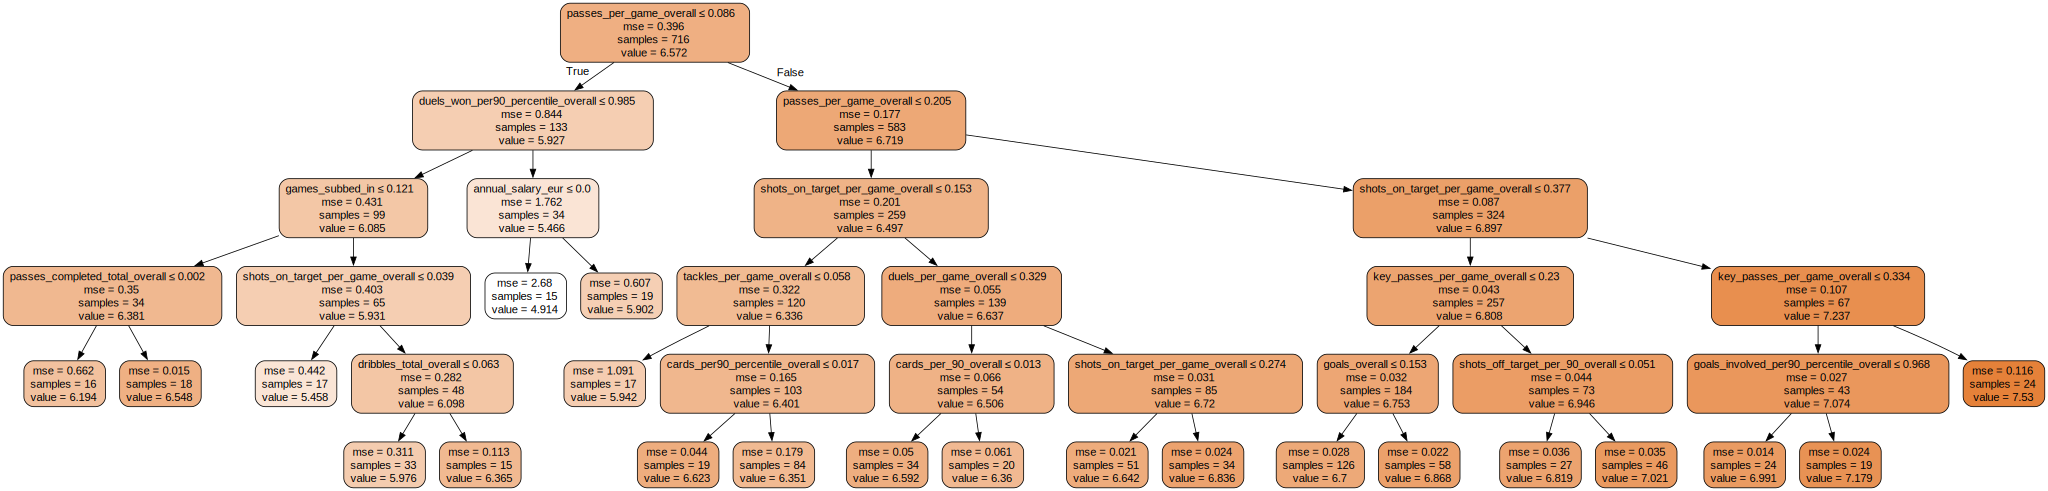

In [248]:
best_dt_model_4 = dt_model_cv_4.best_estimator_

draw_tree(best_dt_model_4, labels_4, filename = "dt_forward")

In [249]:
feature_importances_dt_4 = best_dt_model_4.feature_importances_
feature_names = labels_4

top_feature_dt_4 = print_feature_importance_tree(feature_importances_dt_4, labels_4)

Top 5 Feature Importances:
1. passes_per_game_overall: 0.6009610129715698
2. shots_on_target_per_game_overall: 0.14244946357664734
3. duels_won_per90_percentile_overall: 0.06419269145778214
4. annual_salary_eur: 0.05412826090222483
5. key_passes_per_game_overall: 0.03409718839313746

Bottom 5 Feature Importances:
1. hattricks_total_overall: 0.0
2. two_goals_in_a_game_total_overall: 0.0
3. three_goals_in_a_game_total_overall: 0.0
4. booked_over05_percentage_overall: 0.0
5. shirt_number: 0.0


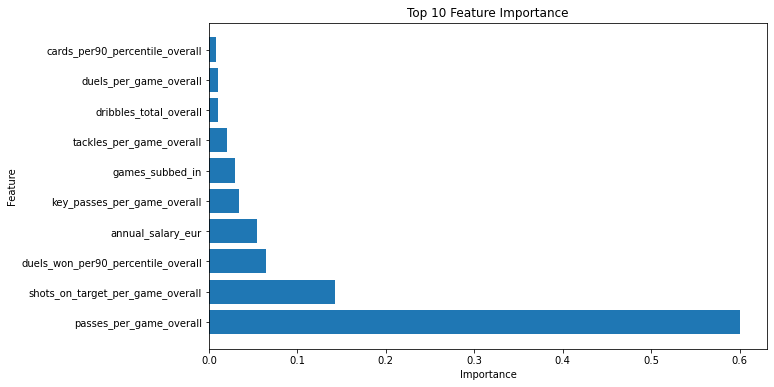

In [250]:
plot_feature_importance_tree(feature_importances_dt_4, labels_4)

#### We now use an ensembling method (Random Forest) to mitigate overfitting:

Without Cross Validation

In [251]:
rf_model_4, mse_rf_4_noncv = train_tree_regressors(X_train_scaled_4, y_train_4, X_test_scaled_4, y_test_4,
                                 algorithm = "rf_reg", cross_validation = False, max_depth = 5, min_samples_leaf = 5)


Mean Squared Error (MSE) - Random Forest : 0.2924311576171017
Mean Absolute Error (MAE) - Random Forest : 0.30879212070982776


With Cross Validation

In [252]:
rf_model_cv_4, mse_rf_4 = train_tree_regressors(X_train_scaled_4, y_train_4, X_test_scaled_4, y_test_4,
                                 algorithm = "rf_reg", cross_validation = True)

mse_list_4.append(mse_rf_4)

Best Parameters for Random Forest: {'max_depth': 9, 'min_samples_leaf': 15}
Mean Squared Error (MSE) - Random Forest CV: 0.2718366484153088
Mean Absolute Error (MAE) - Random Forest CV: 0.304772745814199


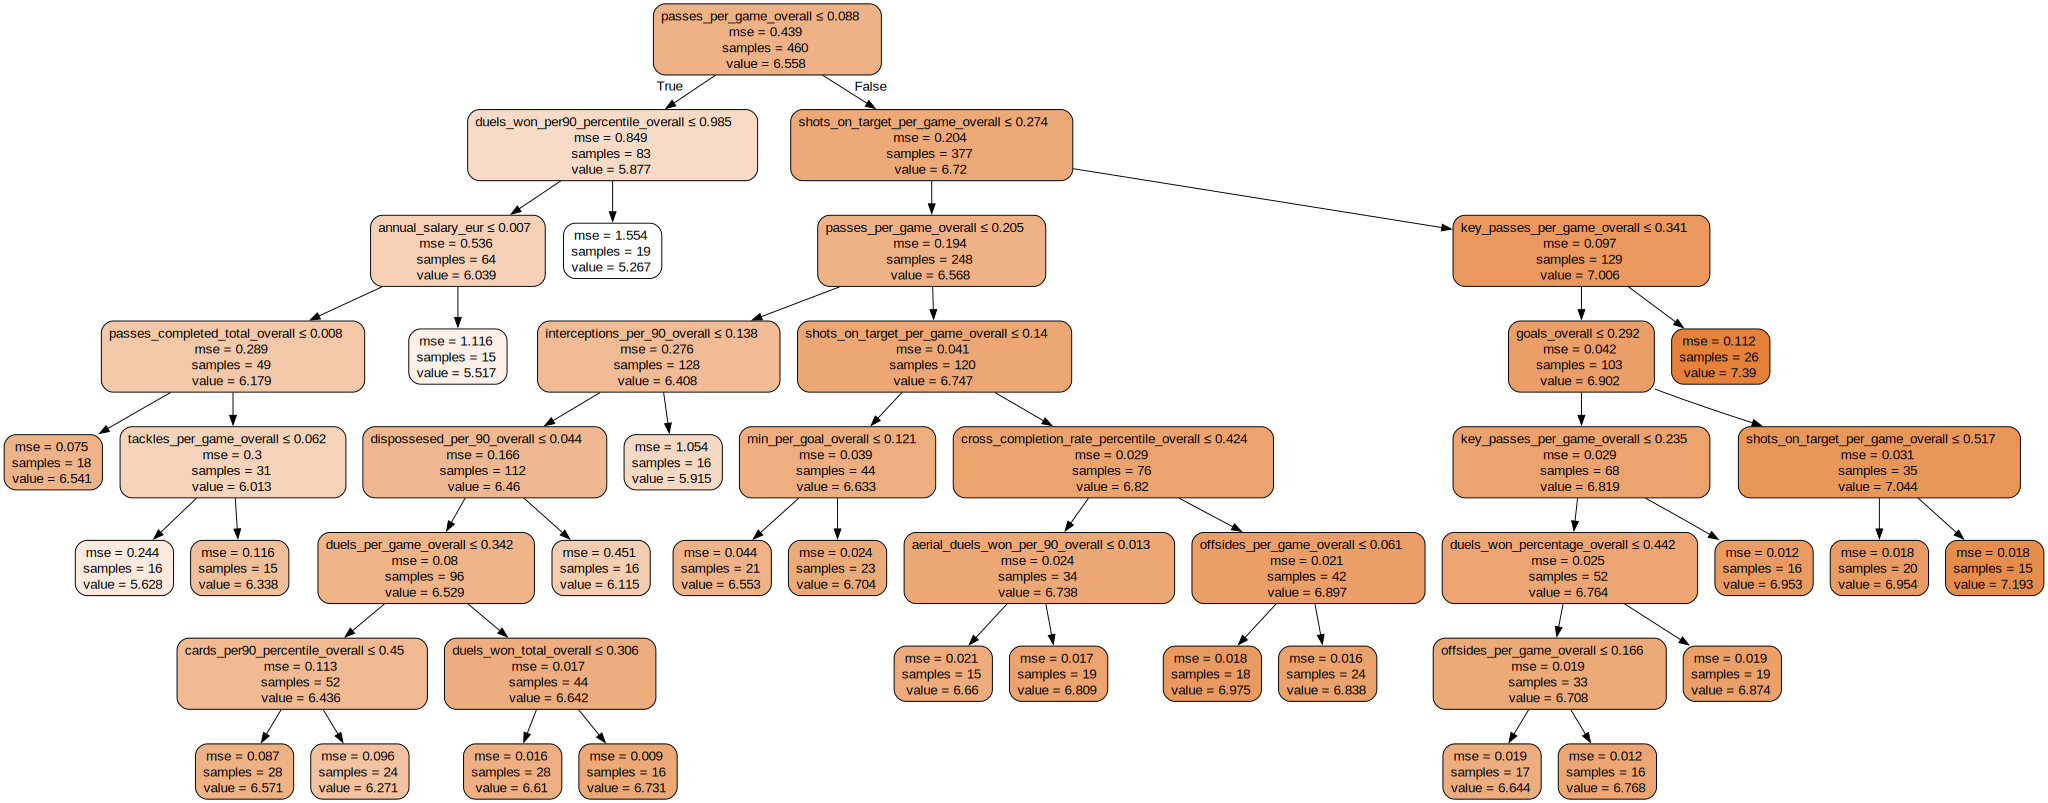

In [253]:
#We visualise one tree (the last one for example)

best_rf_model_4 = rf_model_cv_4.best_estimator_


tree_in_forest = best_rf_model_4.estimators_[-1]

draw_tree(tree_in_forest, labels_4, filename = "rf_forward")

In [254]:
importancesrf_4 = best_rf_model_4.feature_importances_
top_feature_rf_4 = print_feature_importance_tree(importancesrf_4, labels_4)

Top 5 Feature Importances:
1. passes_per_game_overall: 0.37662443230600845
2. key_passes_per_game_overall: 0.14260379774509532
3. shots_on_target_per_game_overall: 0.11801617940403712
4. duels_per_game_overall: 0.05942976769915659
5. passes_completed_total_overall: 0.053060239251136704

Bottom 5 Feature Importances:
1. punches_per_game_overall: 0.0
2. penalties_won_total_overall: 0.0
3. distance_travelled_per90_percentile_overall: 0.0
4. hattricks_total_overall: 0.0
5. three_goals_in_a_game_total_overall: 0.0


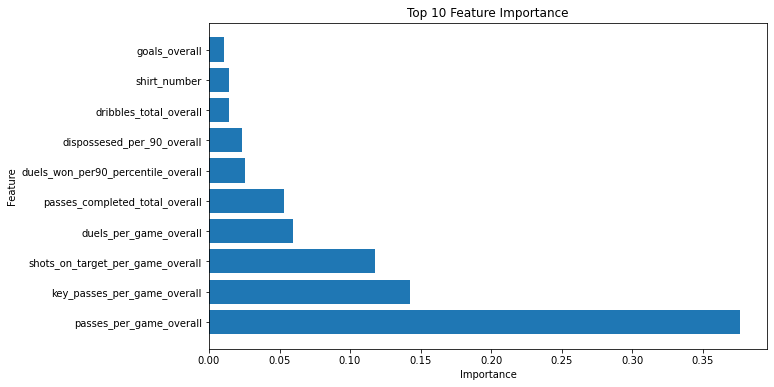

In [255]:
# Calculate feature importances
plot_feature_importance_tree(importancesrf_4, labels_4)

###Gradient Boosting Regressor (XGBoost)

With Cross-Validation

In [256]:
XGB_model_cv_4, mse_xgb_4 = train_tree_regressors(X_train_scaled_4, y_train_4, X_test_scaled_4, y_test_4,
                          algorithm = "XGB_reg")

mse_list_4.append(mse_xgb_4)

Best Parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 5}
Mean Squared Error (MSE) - XGBoost CV: 0.34729968266883177
Mean Absolute Error (MAE) - XGBoost CV: 0.3376924742799897


Without Cross-Validation

In [257]:
XGB_model_4, xgb_mse_4_noncv = train_tree_regressors(X_train_scaled_4, y_train_4, X_test_scaled_4, y_test_4,
                          algorithm = "XGB_reg", cross_validation = False)

Mean Squared Error (MSE) - XGBoost : 0.3725016305656668
Mean Absolute Error (MAE) - XGBoost : 0.33460532865044795


In [258]:
importancesxgb_4 = XGB_model_cv_4.best_estimator_.feature_importances_
top_feature_xgb_4 = print_feature_importance_tree(importancesxgb_4, labels_4)



Top 5 Feature Importances:
1. passes_per_game_overall: 0.1009964570403099
2. key_passes_per_game_overall: 0.09493181109428406
3. shots_off_target_per_90_overall: 0.05554550513625145
4. tackles_per90_percentile_overall: 0.05140375718474388
5. passes_completed_total_overall: 0.049624957144260406

Bottom 5 Feature Importances:
1. dispossesed_per90_percentile_overall: 0.0
2. distance_travelled_per90_percentile_overall: 0.0
3. accurate_crosses_per90_percentile_overall: 0.0
4. hattricks_total_overall: 0.0
5. three_goals_in_a_game_total_overall: 0.0


### Plot

In [259]:
features_4.append(top_feature_dt_4)
features_4.append(top_feature_rf_4)
features_4.append(top_feature_xgb_4)

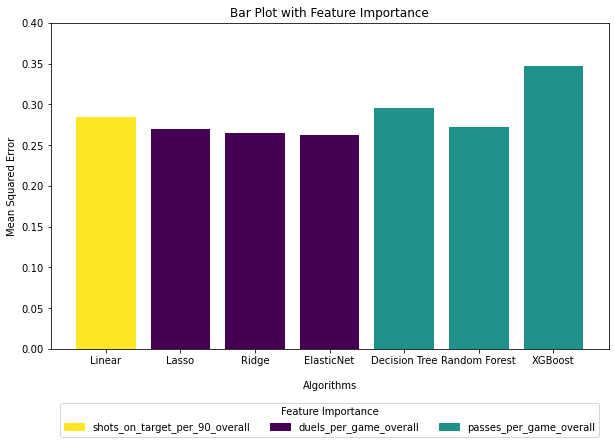

In [262]:
plot_and_save(algorithms, mse_list_4, features_4, filename = "plot_4.png", ylim = 0.4)